In [34]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import linregress

# 1. Data Retrieval and Cleanup

In this section, we will prepare our raw CDC data for visual and quantitative analysis. We were very fortunate to find such a wealth of data. Thank you, CDC! Only about 6% of the raw dataset could be considered "clean" (no missing datapoints), but the original dataset was so large that we retained nearly half a million rows of patient data.

In [2]:
# df = pd.read_csv('http://data.cdc.gov/api/views/vbim-akqf/rows.csv?accessType=DOWNLOAD')
# If you already have the csv file downloaded, replace the above code with: 
    # df = pd.read_csv(<PATH_TO_CSV>)
df = pd.read_csv('/home/harry/Documents/COVID-19_Case_Surveillance_Public_Use_Data.csv')

/home/harry/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Rename columns for ease of visibility
renames = {'Black, Non-Hispanic': 'Black', 'White, Non-Hispanic': 'White', 'Hispanic/Latino': 'Hispanic',
           'Asian, Non-Hispanic': 'Asian', 'Multiple/Other, Non-Hispanic':'Other', 
           'American Indian/Alaska Native, Non-Hispanic': 'Native', 
           'Native Hawaiian/Other Pacific Islander, Non-Hispanic': 'Pacific Islander'}
for key in renames.keys():
    df = df.replace(key, renames[key])
df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/10,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,Black,No,Unknown,No,No
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,Black,No,No,No,No
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,Male,10 - 19 Years,Black,No,No,No,No
3,2020/11/14,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,Black,Missing,Missing,No,Missing
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,Black,No,No,No,Yes


In [4]:
# Extract month from date
def getMonth(date):
    return date[5:7]
df['month'] = df['cdc_report_dt'].apply(getMonth)


In [5]:
# Get rid of missing and unknown data
df = df.replace(['Missing', 'Unknown'], np.nan) #no interest in these rows
df = df.replace('No', 0)
df = df.replace('Yes', 1)

df = df.replace('Male', 1)
df = df.replace('Female', 0)

df['sex'] = df['sex'].replace('Other', np.nan) #Negligle - only like 30 people are "other" in this dataset

#We don't mind keeping nan values for date data, 
#so we need to replace nan with something that won't be dropped by dropna
df['pos_spec_dt'] = df['pos_spec_dt'].replace(np.nan, '--')
df['onset_dt'] = df['onset_dt'].replace(np.nan, '--')
dropped = df.dropna()
df.head()

# We still have almost half a million rows that have every single one of our desired datapoints

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,month
0,2020/11/10,2020/11/10,--,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,NaN,0.0,0.0,11
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11
3,2020/11/14,2020/11/10,--,Laboratory-confirmed case,1.0,10 - 19 Years,Black,NaN,NaN,0.0,NaN,11
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,1.0,11


In [6]:
# Save clean dataframe
dropped.to_csv('Data/clean_data.csv', index=False)

## Bias
### Have we introduced bias into our sample?
We have cut down our sample size by more than 90%. Thankfully, even when we're extremely picky, and we don't allow for *any* datapoints to be missing (convenient for quantitative analysis), we still have almost half a *million* cases of Covid-19 to examine.

Thanks to the CDC's huge amount of data collected, we can prune down the data, and we still have 10x the sample size that Pfizer had for its phase 3 Covid vaccine trials (which just got approved

So, we don't have to worry about whether or not we have removed *too much* of the dataset, but we do have to worry about the possibility of bias. Did we remove rows randomly, or did we introduce bias? 

---
### Random selection
To understand why the question of randomness is so important, think of a simple example: You have a dataset of one billion men, sampled from the globe at random. The two columns of information are height and nationality. You find that the average height for men is 176.5 cm. Now, think of three distinct scenarios:

Scenario 1: You RANDOMLY select 1000 (0.1%) of the men. Do you think the average height will still be 176.5 cm?

Scenario 2: You select 1000 men, but you make sure they are ALL from the country of Norway (an especially tall country). Now, do you think the new average will reflect the global average?

Scenario 3: You select 1000 men, but you make sure that you ONLY select men who wore red hats today. Now, do you think the new average will reflect the global average?

Both scenario 2 and 3 are highly UN-random, but only one is a biased sample of height. The sample average height for scenario 3 should yield the same value as the global population average. This is because nationality correlates with height, and the wearing of red hats does not.

---
### CDC Data Sampling
This is the question we need to be asking ourselves: Is our selection criteria (the full availability of hospital data) correlated with our dependent variable (death)?
When we drop these 7.5 million incomplete rows, is it more akin to the nationality example, or the red hats example?

We can explore this question intuitively and quantitatively. Intuitively, I would make the argument that there is unlikely to be any correlation between a hospital's data-reporting and its patient outcomes. I imagine that the staff who generate these datasets are not doctors, and the quality of their work does not reflect the quality of the medical work at these hospitals. I would assume based on intuition that the quality of medical care and the quality of reported data are completely independent of one another. 

One great way to look for bias is to visualize the distribution of population fields. In this case, intuition prevails. The distributions are nearly identical after performing the data pruning.

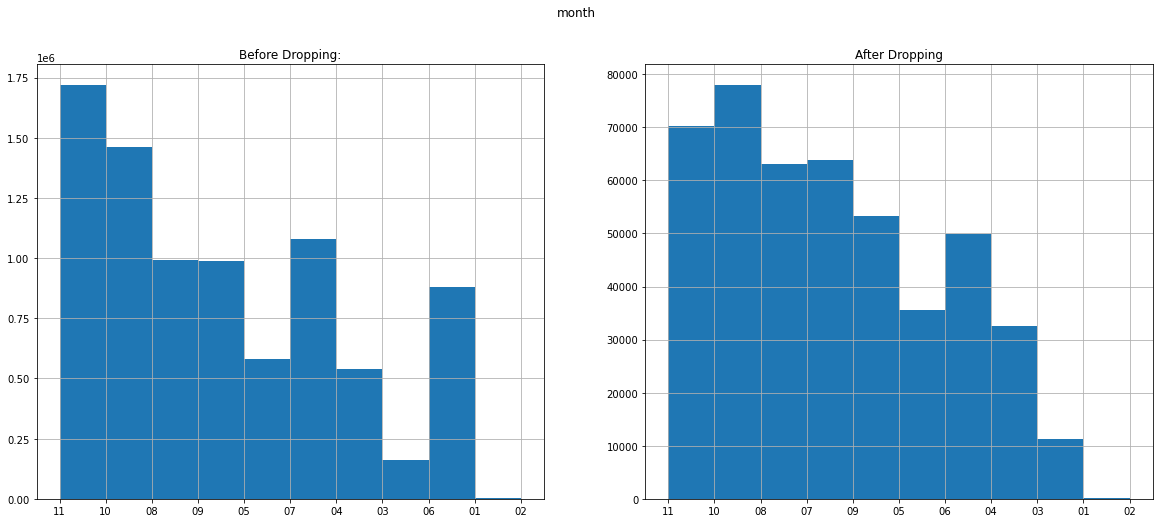

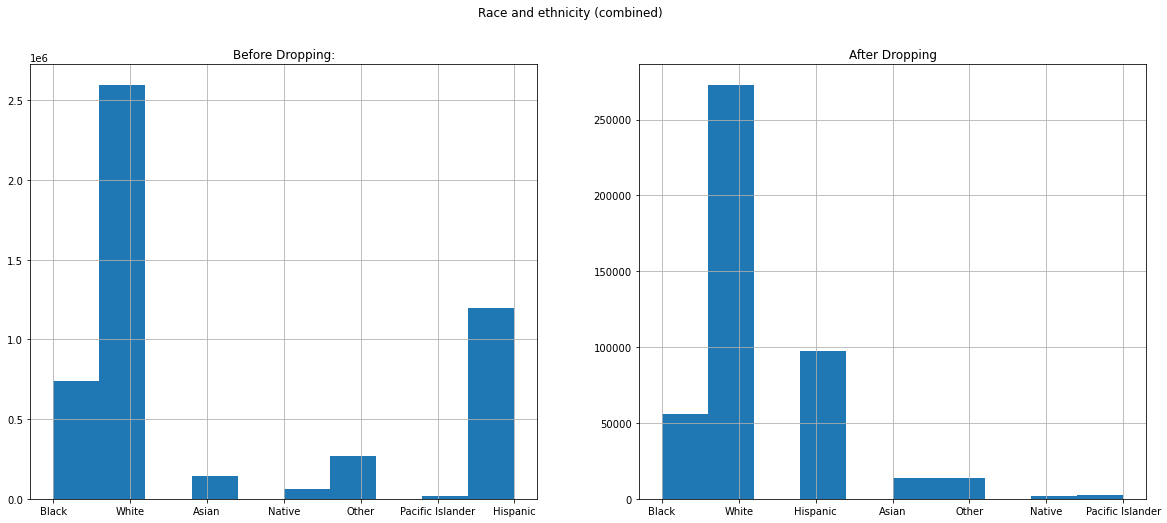

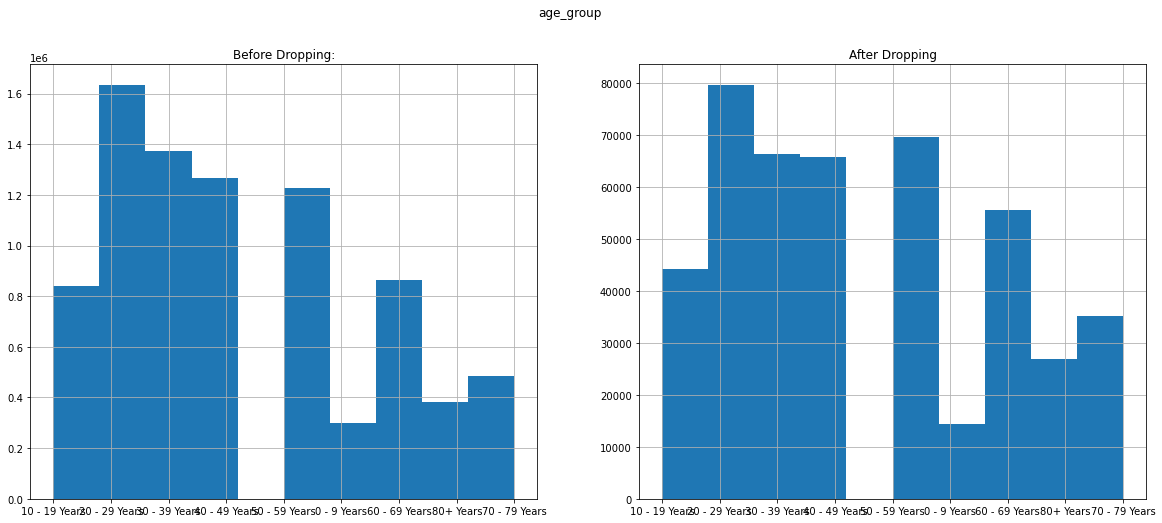

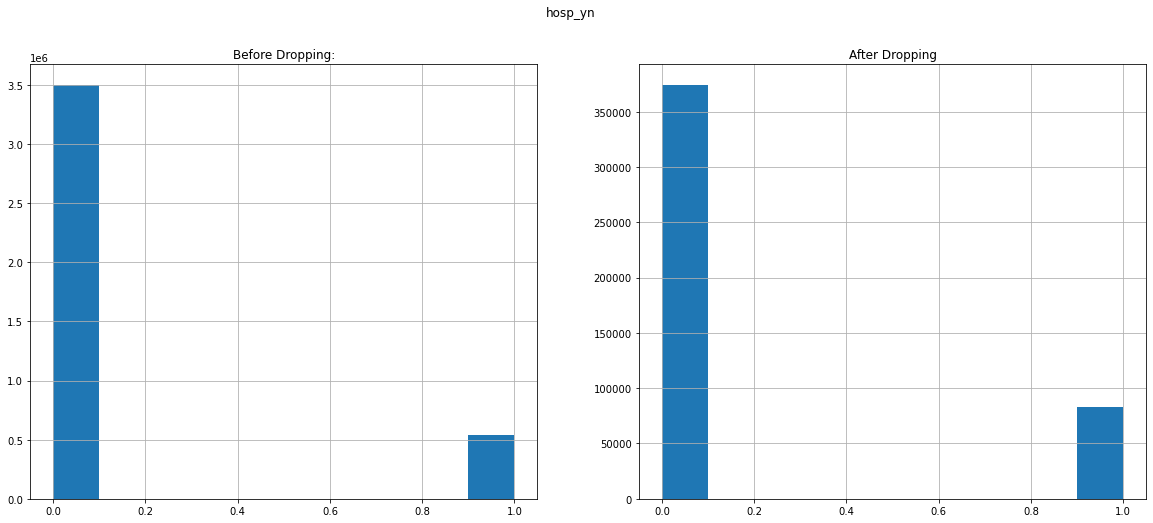

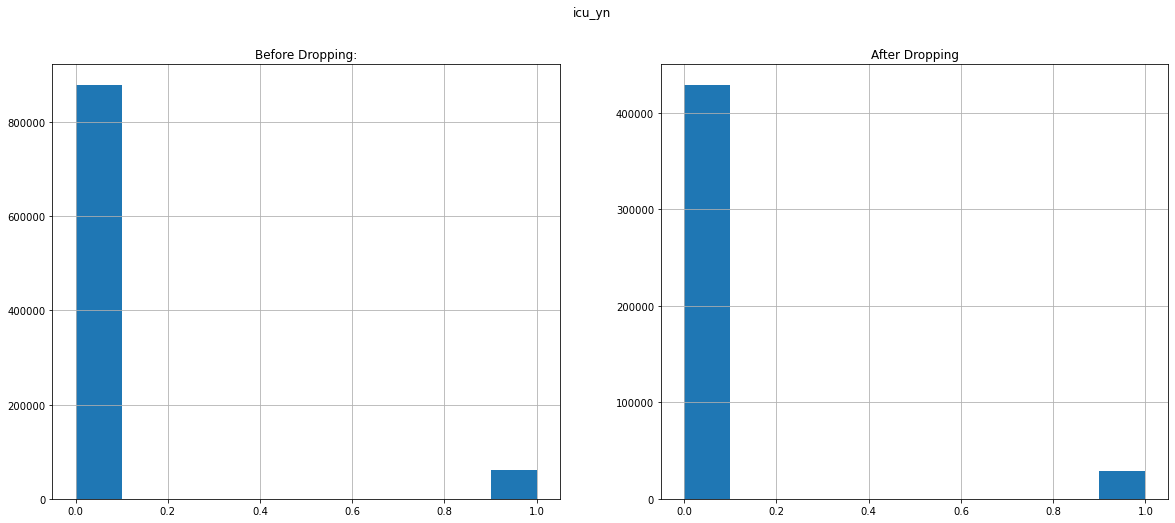

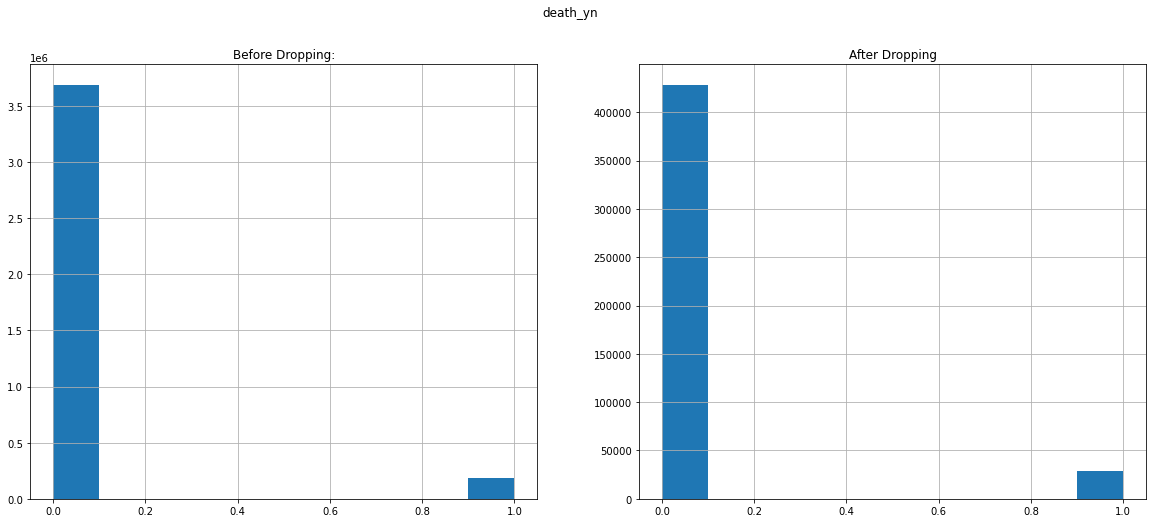

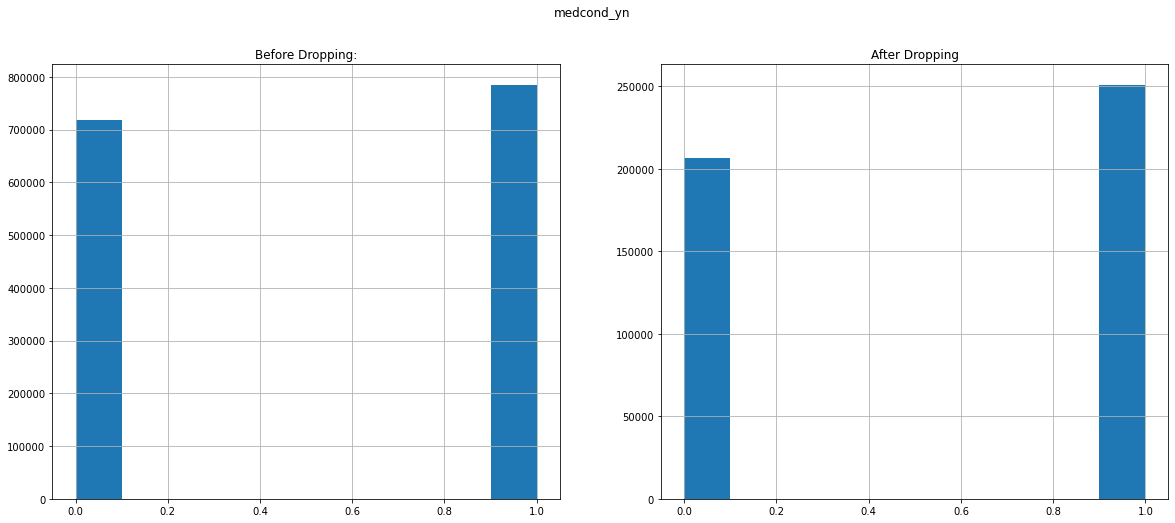

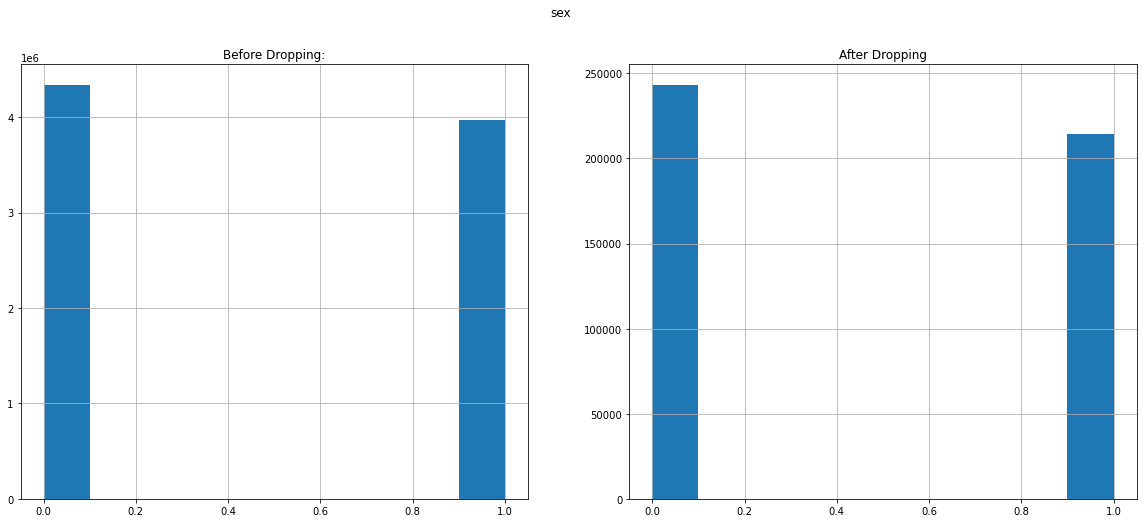

In [7]:
#Generate a histogram of the two dataframes - one with dropped values, the other without
def compareHistogram(col):
    fig, axs = plt.subplots(1,2, figsize= (20,8))
    fig.suptitle(col)
    
    df[col].hist(ax = axs[0])
    axs[0].set_title('Before Dropping:')

    dropped[col].hist(ax = axs[1])
    axs[1].set_title('After Dropping')
    plt.savefig('Images/drop_data_comparisons/' + col + '.png', facecolor = 'white')

    
for column in ['month','Race and ethnicity (combined)', 'age_group', 'hosp_yn','icu_yn','death_yn','medcond_yn', 'sex']:
    compareHistogram(column)

# 1.1 Gather Hospital Data from Health.gov 
We will group this data by month so as to get a general picture of the country 

State-by-state information (like the information in this particular dataset) is not of any interest to our analysis, because there is no location data in the CDC dataset

In [8]:
df = pd.read_csv('https://healthdata.gov/sites/default/files/reported_hospital_utilization_timeseries_20201213_2141.csv')
df

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
0,NJ,2020-08-26,9,63,5,9,63,5,52.0,70,...,615.0,19692.0,0.055507,71.0,64.0,1153.0,1.127426,72.0,1336.0,1185.0
1,NM,2020-08-26,12,34,2,12,34,2,1.0,47,...,111.0,3190.0,0.084746,42.0,30.0,354.0,0.672973,42.0,249.0,370.0
2,NV,2020-08-26,8,49,4,10,47,4,33.0,59,...,832.0,8339.0,0.253450,58.0,202.0,797.0,0.758980,61.0,655.0,863.0
3,NY,2020-08-26,8,112,46,7,112,47,18.0,131,...,1566.0,42349.0,0.045967,106.0,212.0,4612.0,0.573216,116.0,2795.0,4876.0
4,OH,2020-08-26,10,82,115,11,79,117,10.0,91,...,1400.0,30450.0,0.087094,184.0,357.0,4099.0,0.643901,192.0,2687.0,4173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,MN,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15483,MT,2020-01-01,0,0,1,0,0,1,0.0,1,...,0.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15484,NC,2020-01-01,0,0,1,0,0,1,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15485,PR,2020-01-01,0,0,1,0,0,1,0.0,1,...,0.0,146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
occupancy = df[['date', 'adult_icu_bed_covid_utilization', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']]

def getMonth(date):
    return date[5:7]

# Group by month
occupancy['month'] = occupancy['date'].apply(getMonth)
occupancy = occupancy.groupby('month', dropna = False).mean()[['adult_icu_bed_covid_utilization', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']]
occupancy

<ipython-input-9-36e569719a3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupancy['month'] = occupancy['date'].apply(getMonth)


,adult_icu_bed_covid_utilization,inpatient_beds_utilization,percent_of_inpatients_with_covid
month,,,
01,0.000000,0.424642,0.000000
02,NaN,0.461779,0.004861
03,NaN,0.518818,0.067229
04,0.076896,0.510773,0.148326
05,NaN,0.600794,0.111960
06,NaN,0.637689,0.078412
07,0.165340,0.664927,0.105063
08,0.151257,0.663529,0.087548
09,0.116432,0.661602,0.068433


In [10]:
# Save Data
df.to_csv('Data/hospital_info.csv', index=False)
occupancy.to_csv('Data/hospital_occupancy.csv')

# 1.2 Merge Hospital Data into Main CDC Dataset

In [11]:
df = pd.read_csv('Data/clean_data.csv')
cap = pd.read_csv('Data/hospital_occupancy.csv', index_col = False)
cap

,month,adult_icu_bed_covid_utilization,inpatient_beds_utilization,percent_of_inpatients_with_covid
0,1,0.000000,0.424642,0.000000
1,2,NaN,0.461779,0.004861
2,3,NaN,0.518818,0.067229
3,4,0.076896,0.510773,0.148326
4,5,NaN,0.600794,0.111960
5,6,NaN,0.637689,0.078412
6,7,0.165340,0.664927,0.105063
7,8,0.151257,0.663529,0.087548
8,9,0.116432,0.661602,0.068433
9,10,0.139070,0.680998,0.084843


In [12]:
# Perform Merge
df = pd.merge(df, cap[['month', 'inpatient_beds_utilization', 'percent_of_inpatients_with_covid']], on = 'month').rename(columns={
    
    'inpatient_beds_utilization': 'inpatient__occupancy'
    
})
df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
1,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
2,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,1.0,11,0.688734,0.1512
3,2020/11/09,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
4,2020/11/06,2020/11/10,2020/11/06,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,1.0,11,0.688734,0.1512


In [13]:
# Save (and overwrite) data.
df.to_csv('Data/clean_data.csv', index= False)

# 2. Data Exploration and Visualization

## Gender

In [14]:
df = pd.read_csv('./Data/clean_data.csv')

# Are more men dying from COVID-19 than woman ?

clean_data_df = df

# Calculate the distribution of female versus male COVID-19 Cases
total_cases= len(clean_data_df['sex'])

by_gender_count=clean_data_df["sex"].value_counts()

by_gender_pct = (100*(by_gender_count/total_cases)).round(2)

# Calculate the distribution of female versus male deaths by COVID-19
death = clean_data_df[(clean_data_df['death_yn'] == 1.0)]
total_death = len(death['death_yn'])
by_gender_death=death["sex"].value_counts()
by_gender_death_pct = (100*(by_gender_death/total_death)).round(2)


# Calculate the distribution of female versus male deaths with underlying medical condition by COVID-19
death_med_cond = death[(death['medcond_yn'] == 1.0)]
total_death_med_cond = len(death_med_cond['medcond_yn'])
by_gender_death_med_cond = death_med_cond["sex"].value_counts()
by_gender_death_med_cond_pct = (100*(by_gender_death_med_cond/total_death_med_cond)).round(2)

# Assemble the resulting series into a single summary dataframe.
gender_df = pd.DataFrame({"Sex": ["Female", "Male"],
                          "Number of Cases": by_gender_count,
                          "Share of Cases (%)": by_gender_pct,
                          "Number of Deaths":by_gender_death,
                          "Share of Deaths (%)":by_gender_death_pct,
                          "Deaths with underlying condition": by_gender_death_med_cond,
                          "Share of Death with underlying condition (%)":by_gender_death_med_cond_pct })

gender_df

,Sex,Number of Cases,Share of Cases (%),Number of Deaths,Share of Deaths (%),Deaths with underlying condition,Share of Death with underlying condition (%)
0.0,Female,243408,53.18,12396,42.5,11683,42.49
1.0,Male,214323,46.82,16773,57.5,15815,57.51


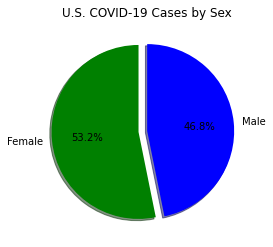

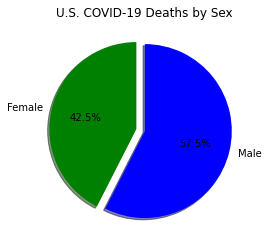

In [15]:
### COVID-19 Cases and Deaths Disaggregated by Sex

# Pie plot showing the distribution of male versus female COVID-19 Cases

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Cases (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Cases by Sex")

plt.savefig('Images/US_Covid_cases_by_sex.png')
plt.show()

# Pie plot showing the distribution of male versus female deaths by COVID-19 Cases

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Deaths (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths by Sex")

plt.savefig('Images/US_Covid_deaths_by_sex.png')
plt.show()

In [16]:
### Rate Ratio of COVID-19 by Sex Mortality Rate

total_pct_deaths =(100*(by_gender_death/total_cases)).round(2)


sex_ratio_df = pd.DataFrame({"Sex": ["Female", "Male"],
                          "Number of Cases": by_gender_count,
                          "Number of Deaths":by_gender_death,
                          "Total Deaths (%)":total_pct_deaths})
sex_ratio_df

,Sex,Number of Cases,Number of Deaths,Total Deaths (%)
0.0,Female,243408,12396,2.71
1.0,Male,214323,16773,3.66


Men have 1.4 chances of dying than women.
For every 10 deaths among confirmed cases in women, there are 14 death in men.


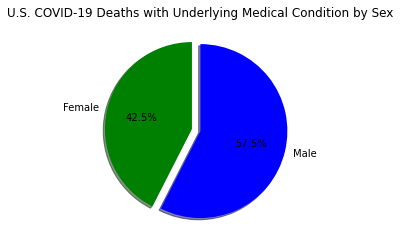

In [17]:
male_female_radio = (total_pct_deaths[1]/total_pct_deaths[0]).round(1)
print(f'Men have {male_female_radio} chances of dying than women.')
print(f'For every 10 deaths among confirmed cases in women, there are {"{:.0f}".format(10*male_female_radio)} death in men.')

### Possible Risk Factors  

# Pie plot showing the distribution of male versus female deaths by COVID-19 Cases with underlying medical condition

# Create Labels for the sections of the pie
labels = gender_df["Sex"]
distribution = gender_df["Share of Death with underlying condition (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['green', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths with Underlying Medical Condition by Sex")

plt.savefig('Images/US_Covid_deaths_with_medcond_by_sex.png')
plt.show()

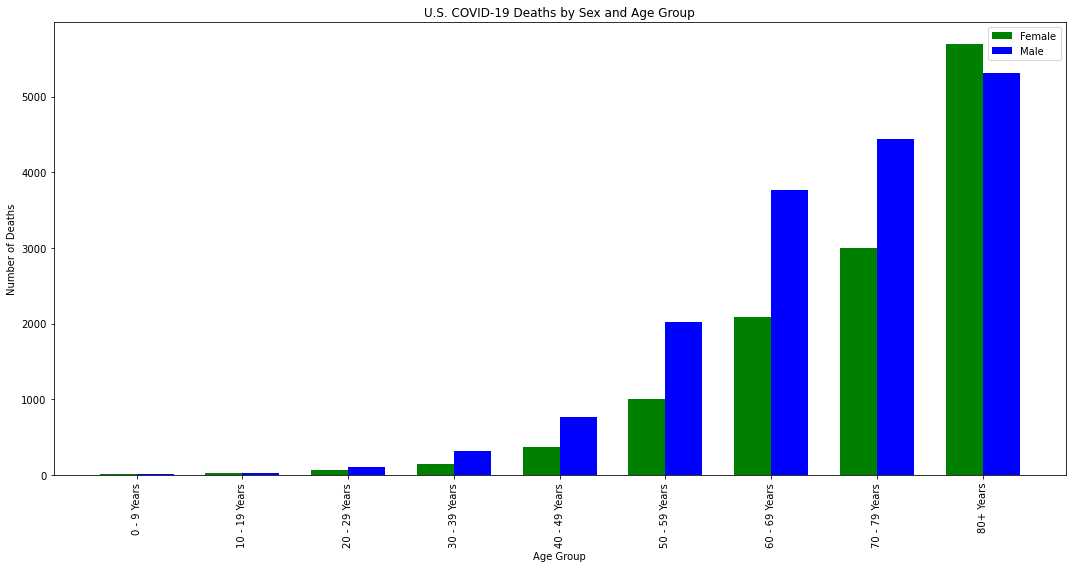

In [73]:
# Calculating the distribution of male versus female deaths by COVID-19 Cases base on age groups

# Number of death in womens by age groups
woman_death = clean_data_df[((clean_data_df['sex'] == 0) & (clean_data_df['death_yn'] == 1.0))]
woman_age_group_deaths = woman_death.groupby(["age_group"]).count()["death_yn"]

# Number of death in male by age group 
men_death = clean_data_df[((clean_data_df['sex'] == 1.0) & (clean_data_df['death_yn'] == 1.0))]
men_age_group_deaths = men_death.groupby(["age_group"]).count()["death_yn"]
men_age_group_deaths

# Bar plot showing the distribution of male versus female deaths by COVID-19 Cases base on age groups

labels = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years',
        '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years', '80+ Years']
y = woman_age_group_deaths
y1 = men_age_group_deaths

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,8))
rects1 = ax.bar(x - width/2, y, width, label='Female', color='g')
rects2 = ax.bar(x + width/2, y1, width, label='Male', color='b')
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Deaths')
ax.set_title('U.S. COVID-19 Deaths by Sex and Age Group')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()
fig.tight_layout()

plt.savefig('Images/US_Covid_deaths_by_sex_and_age.png')
plt.show()

In [19]:
## Are people with underlying health conditions at higher risk of serious symptoms of COVID-19?

clean_data_df = df

# Calculate the distribution of COVID-19 Cases with underlying health condicions.
total_cases= len(clean_data_df['medcond_yn'])
med_cond_count=clean_data_df["medcond_yn"].value_counts()
med_cond_pct = (100*(med_cond_count/total_cases)).round(2)

# Calculate the distribution with underlying health condicions deaths by COVID-19
death = clean_data_df[(clean_data_df['death_yn'] == 1.0)]
total_death = len(death['death_yn'])
med_cond_death=death["medcond_yn"].value_counts()
med_cond_death_share = (100*(med_cond_death/total_death)).round(2)
med_cond_death_pct = (100*(med_cond_death/total_cases)).round(2)

# Calculate the distribution hospitalization with underlying medical condition by COVID-19
hospitalization = clean_data_df[(clean_data_df['hosp_yn'] == 1.0)]
total_hospitalization = len(hospitalization['hosp_yn'])
med_cond_hospitalization=hospitalization["medcond_yn"].value_counts()
med_cond_hospitalization_share = (100*(med_cond_hospitalization/total_hospitalization)).round(2)
med_cond_hospitalization_pct = (100*(med_cond_hospitalization/total_cases)).round(2)

# Calculate the distribution ICU admission with underlying medical condition by COVID-19
icu = clean_data_df[(clean_data_df['icu_yn'] == 1.0)]
total_icu = len(icu['icu_yn'])
med_cond_icu=icu["medcond_yn"].value_counts()
med_cond_icu_share = (100*(med_cond_icu/total_icu)).round(2)
med_cond_icu_pct = (100*(med_cond_icu/total_cases)).round(2)

# Assemble the resulting series into a single summary dataframe.
med_cond_df = pd.DataFrame({"Medical Condition": ["Yes", "No"],
                          "Number of Cases": med_cond_count,
                          "Cases (%)": med_cond_pct,
                          "Number of Hospitalizations": med_cond_hospitalization,
                          "Share of Hospitalizations (%)": med_cond_hospitalization_share,
                          "Hospitalizations (%)": med_cond_hospitalization_pct, 
                          "Number of ICU Admissions": med_cond_icu,
                          "Share of ICU Admissions (%)": med_cond_icu_share,
                          "ICU Admissions (%)": med_cond_icu_pct,
                          "Number of Deaths": med_cond_death,
                          "Share of Death (%)": med_cond_death_share,
                          "Death (%)": med_cond_death_pct})
med_cond_df

,Medical Condition,Number of Cases,Cases (%),Number of Hospitalizations,Share of Hospitalizations (%),Hospitalizations (%),Number of ICU Admissions,Share of ICU Admissions (%),ICU Admissions (%),Number of Deaths,Share of Death (%),Death (%)
1.0,Yes,251103,54.86,70545,84.72,15.41,25575,89.06,5.59,27498,94.27,6.01
0.0,No,206628,45.14,12725,15.28,2.78,3140,10.94,0.69,1671,5.73,0.37


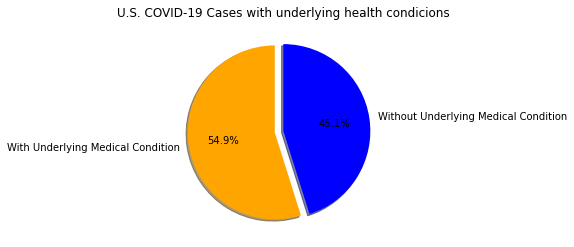

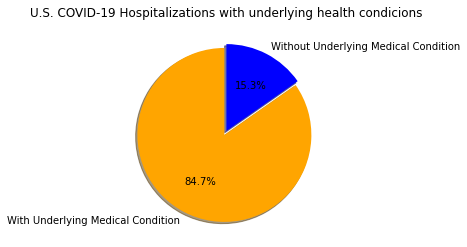

In [20]:
### Plots of distribution of COVID-19 Cases by shares with and without underlying health condicions.

# Pie plot showing the distribution of COVID-19 Cases with and without underlying health condicions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Cases (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.1, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Cases with underlying health condicions")

plt.savefig('Images/US_Covid_cases_with_medcond.png')
plt.show()

# Pie plot showing the distribution of COVID-19 Hospitalizations with and without underlying health condicions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of Hospitalizations (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Hospitalizations with underlying health condicions")

plt.savefig('Images/US_Covid_hospitalizations_with_medcond.png')
plt.show()

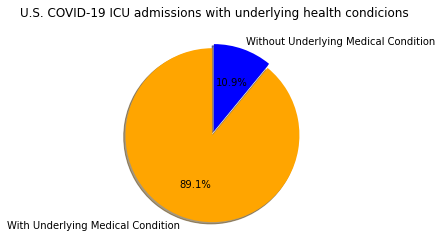

In [21]:
# Pie plot showing the distribution of COVID-19 ICU admissions with and without underlying health condicions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of ICU Admissions (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 ICU admissions with underlying health condicions")

plt.savefig('Images/US_Covid_ICU_with_medcond.png')
plt.show()

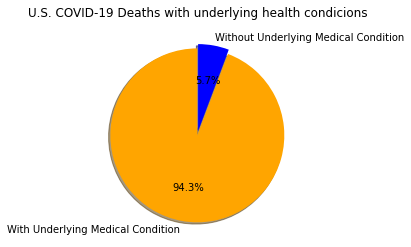

In [22]:
# Pie plot showing the distribution of COVID-19 Deaths with and without underlying health condicions

# Create Labels for the sections of the pie
labels = ["With Underlying Medical Condition","Without Underlying Medical Condition" ]
distribution = med_cond_df["Share of Death (%)"]

# Pie plot using pyplot
plt.pie(distribution, labels=labels, colors = ['orange', 'blue'],explode = (0.05, 0), autopct="%1.1f%%",shadow=True, startangle=90 )

#Formatting
plt.title("U.S. COVID-19 Deaths with underlying health condicions")

plt.savefig('Images/US_Covid_deaths_with_medcond.png')
plt.show()

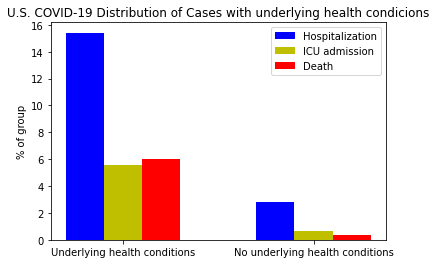

In [23]:
### Bar plot of distribution of COVID-19 Risk with underlying health condicions.

# Bar plot showing the distribution of COVID-19 Cases with underlying health condicions.

labels = ['Underlying health conditions', 'No underlying health conditions']
y1 = med_cond_hospitalization_pct
y2 = med_cond_icu_pct
y3 = med_cond_death_pct

x = np.arange(len(labels))  # the label locations
width = 0.2


fig, ax = plt.subplots()
rects2 = ax.bar(x - width, y1, width, label='Hospitalization', color='b')
rects3 = ax.bar(x , y2, width, label='ICU admission', color='y')
rects4 = ax.bar(x + width, y3, width, label='Death', color='r')
ax.set_ylabel('% of group')
ax.set_title('U.S. COVID-19 Distribution of Cases with underlying health condicions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='horizontal')
ax.legend()

plt.savefig('Images/US_Covid_distribution_of_cases_with_medcond.png')
plt.show()

In [24]:
###  Risk Rate Ratio of COVID-19 Cases with underlying health condicions.

# Hospitalization risk ratio
hospitalization_radio = (med_cond_hospitalization_pct[1]/med_cond_hospitalization_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {hospitalization_radio} times as likely to be hospitalized.')

# ICU admission risk ratio
ICU_radio = (med_cond_icu_pct[1]/med_cond_icu_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {ICU_radio} times as likely to be ICU admitted.')

# Death risk ratio
death_radio = (med_cond_death_pct[1]/med_cond_death_pct[0]).round(1)
print(f'COVID-19 patients with an underlying medical condition are {ICU_radio} times as likely to die.')

COVID-19 patients with an underlying medical condition are 5.5 times as likely to be hospitalized.
COVID-19 patients with an underlying medical condition are 8.1 times as likely to be ICU admitted.
COVID-19 patients with an underlying medical condition are 8.1 times as likely to die.


In [25]:
### Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S.

# Import the data from Centers for Disease Control and Prevention
med_condition_df = pd.read_csv('http://data.cdc.gov/api/views/hk9y-quqm/rows.csv?accessType=DOWNLOAD')

# Data conditioning
med_condition_df = med_condition_df.replace('COVID-19', 0)
indexNames = med_condition_df[med_condition_df['Condition Group'] == 0 ].index
med_condition_df.drop(indexNames , inplace=True)

# Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S. 
med_condition_df

,Data as of,Start Week,End Week,State,Condition Group,Condition,ICD10_codes,Age Group,Number of Mentions,Flag
0,12/06/2020,02/01/2020,12/05/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,175.0,NaN
1,12/06/2020,02/01/2020,12/05/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,853.0,NaN
2,12/06/2020,02/01/2020,12/05/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,2174.0,NaN
3,12/06/2020,02/01/2020,12/05/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,6220.0,NaN
4,12/06/2020,02/01/2020,12/05/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,15295.0,NaN
...,...,...,...,...,...,...,...,...,...,...
12365,12/06/2020,02/01/2020,12/05/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",65-74,146.0,NaN
12366,12/06/2020,02/01/2020,12/05/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",75-84,152.0,NaN
12367,12/06/2020,02/01/2020,12/05/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",85+,113.0,NaN
12368,12/06/2020,02/01/2020,12/05/2020,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",Not stated,0.0,NaN


In [26]:
# Save clean dataframe
med_condition_df.to_csv('./Data/preexisten_med_conditions_data.csv', index=False)

# Medical Condition data frame
drop_columns = med_condition_df.drop(columns=['Data as of','Start Week', 'End Week','State', 'ICD10_codes', 'Age Group', 'Number of Mentions', 'Flag'])
drop_columns

condition_df = pd.DataFrame(drop_columns.groupby(["Condition Group"]).count())
condition_df.columns = ["Total Count"]
condition_df = condition_df.sort_values(by='Total Count', ascending=False)

# Calculate percentage
condition_df["Condition Percentage (%)"] = (100*(condition_df["Total Count"]/condition_df["Total Count"].sum())).round(2)

condition_df

,Total Count,Condition Percentage (%)
Condition Group,,
Circulatory diseases,3770,31.84
Respiratory diseases,3220,27.20
All other conditions and causes (residual),540,4.56
Alzheimer disease,540,4.56
Diabetes,540,4.56
Malignant neoplasms,540,4.56
Obesity,540,4.56
Renal failure,540,4.56
Sepsis,540,4.56


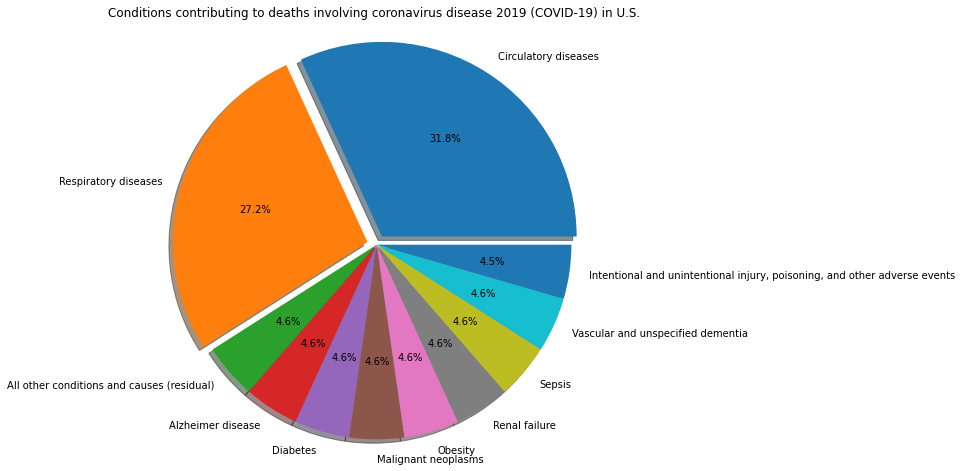

In [27]:
# Pie plot showing conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S. 

# Create Labels for the sections of the pie
labels = condition_df.index
condition = condition_df['Condition Percentage (%)']
explode = (0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)

# Pie plot using pyplot
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(condition, explode=explode, labels=labels , autopct='%1.1f%%', shadow=True)
ax1.axis('equal')  

#Formatting
plt.title("Conditions contributing to deaths involving coronavirus disease 2019 (COVID-19) in U.S.")

plt.savefig('Images/US_Covid_med_conditions_contributing_death.png')
plt.show()

## Ethnicity

In [28]:
# Plots here

## Age

In [29]:
# Plots here

## Hospital Capacity

In [30]:
# Read Data file
df = pd.read_csv('./Data/clean_data.csv')

# Display header to get a sense of look and feel
df.head(2)

#Define Month Grouping
grp_stats = df.groupby(['month'])

grp_stats.count().head(2)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
month,,,,,,,,,,,,,
1,16,16,16,16,16,16,16,16,16,16,16,16,16
2,70,70,70,70,70,70,70,70,70,70,70,70,70


In [31]:
#Calculate Death & Covid inpatients Stats per month

# Sum on Death 
sum_dth = grp_stats["death_yn"].sum()

# Total Population Count
totalcnt = grp_stats["death_yn"].count()

#Average Percent of deaths
pct_dth = sum_dth/totalcnt

#Average Covid inpatient percentage
covid_inpatient_pct = grp_stats["percent_of_inpatients_with_covid"].mean()


#Create a dataframe to enable statistical regression and plotting
grp_stats_df = pd.DataFrame({"In Patient Pct" : covid_inpatient_pct,
                             "Dth_Rate" : pct_dth
                             })
grp_stats_df

,In Patient Pct,Dth_Rate
month,,
1,0.000000,0.000000
2,0.004861,0.228571
3,0.067229,0.260440
4,0.148326,0.171560
5,0.111960,0.094997
6,0.078412,0.168010
7,0.105063,0.039583
8,0.087548,0.032629
9,0.068433,0.026141


In [37]:
#Set today's date as a variable
date = pd.to_datetime("today").strftime("%m/%d/%Y")

#Calculate correlation coefficient
Correlation_Coef = round(st.pearsonr(grp_stats_df['In Patient Pct'],grp_stats_df['Dth_Rate'])[0],5)
Correlation_Coef

#Calulate linear formula
x_values = grp_stats_df['In Patient Pct']
y_values = grp_stats_df['Dth_Rate']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

#Record results in a dataframe
linear_formula_Df = pd.DataFrame({
    "Corr Analysis":"In Patient Pct vs Dth_Rate",
    "Slope":slope,
    "Intercept":intercept,
    "rValueCorr_Coef":rvalue,
    "PndasCorr_Coef":Correlation_Coef,
    "StdErr":stderr 
} ,index=[0] )
linear_formula_Df

,Corr Analysis,Slope,Intercept,rValueCorr_Coef,PndasCorr_Coef,StdErr
0,In Patient Pct vs Dth_Rate,-0.278307,0.119409,-0.144091,-0.14409,0.637105


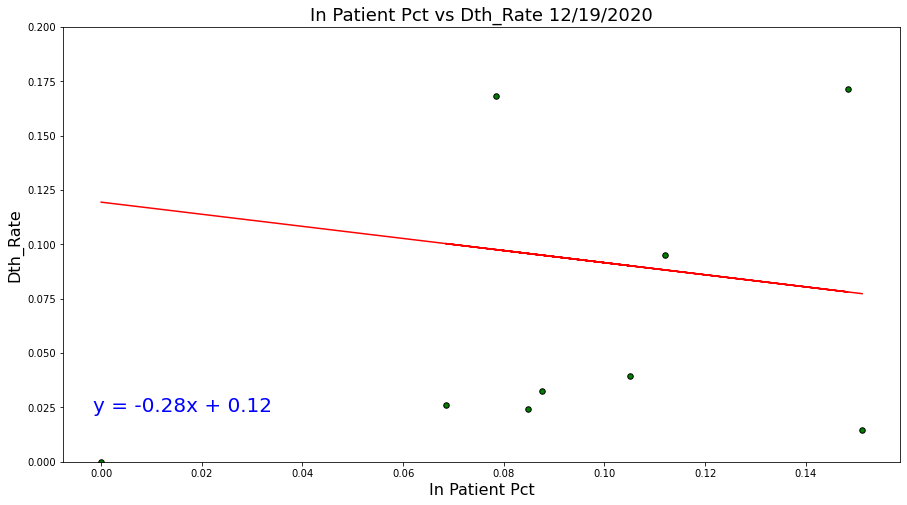

In [38]:
#Create text for plot overlay
line_equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
line_equation

#Plot the linear regression model on top of the scatter plot

# Generate a scatter plot of Max Temp vs. Latitude
# Add the linear regreassion and line to the plot

#Charactorize figure size/layout                       
fig1, ax1 = plt.subplots(figsize=(15, 8))

#Build and format scatter plot based on mean values drawn from the clean_weather_data_df dataframe
plt.scatter(grp_stats_df['In Patient Pct'],grp_stats_df['Dth_Rate'],s=30, edgecolors='black', color="green")

#define title and Lable axis
plt.title('In Patient Pct vs Dth_Rate '+date,fontsize =18)
plt.xlabel('In Patient Pct',fontsize =16)
plt.ylabel('Dth_Rate',fontsize =16)
marker_size = 12

#Establish plot limits
plt.ylim(0, .2)

# Add plot and text of linear regression model 
plt.plot(x_values,regress_values,"r-")
ax1.annotate(line_equation, xy=(.08, .12), xycoords='data',xytext=(0.25, 0.15), textcoords='axes fraction',
             horizontalalignment='right', verticalalignment='top',fontsize=20,color="blue")


#Save image for potential reference in the report
plt.savefig("./Images/Plots/In Patient Pct vs Dth_Rate.png")

plt.show()

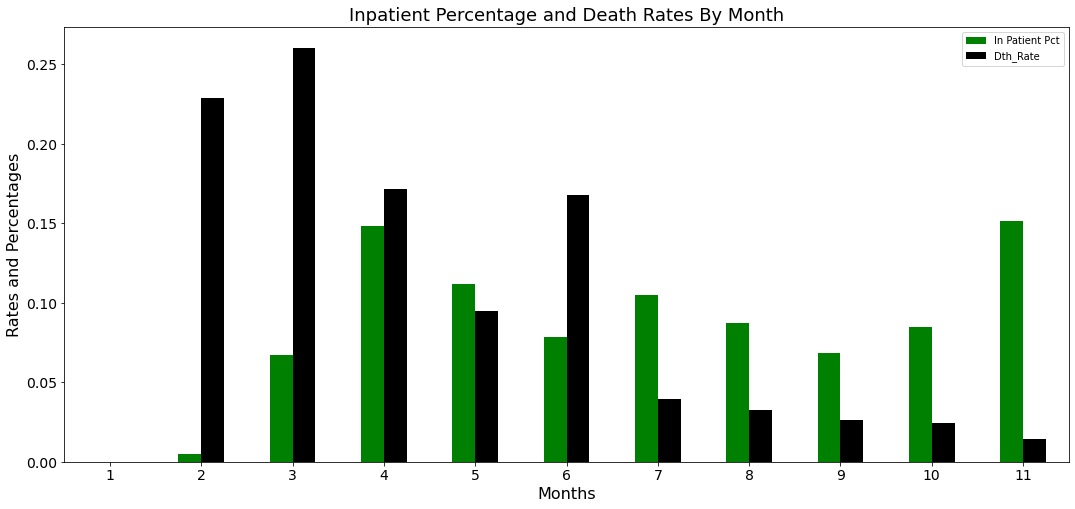

In [39]:
# Generate a bar plot showing the inpatient percentage and death rates by month using pandas.

#Plot Chart
measure_plot = grp_stats_df.plot.bar(figsize=(18,8), color= ['green', 'black'],fontsize = 14)
plt.xlabel("Months",fontsize = 16)
plt.ylabel("Rates and Percentages",fontsize = 16)
plt.title("Inpatient Percentage and Death Rates By Month",fontsize = 18)
plt.xticks(rotation=0)


#Save image for potential reference in the report
plt.savefig("./Images/Plots/inpatient_pct_and_dth_rte_plot_by_mnth.png")

plt.show()

In [40]:
df = pd.read_csv('./Data/clean_data.csv')

# Display header to get a sense of look and feel
df.head(2)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
1,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512


In [41]:
#Define Month Grouping
grp_stats = df.groupby(['month'])

grp_stats.count().head(2)

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
month,,,,,,,,,,,,,
1,16,16,16,16,16,16,16,16,16,16,16,16,16
2,70,70,70,70,70,70,70,70,70,70,70,70,70


In [42]:
#Calculate Death & Covid inpatients Stats per month

# count on number of cases reported
cnt_reported = grp_stats["cdc_report_dt"].count()

# Total Population Count
totalcnt = len(df)

# Sum on Death 
sum_dth = grp_stats["death_yn"].sum()

#Death Count per Case Count
dth_cnt_per_cs_cnt = sum_dth/cnt_reported

#Create month array for plotting
month_list = df['month'].unique()
month_list.sort()


#Create a dataframe to enable statistical regression and plotting
grp_stats_df = pd.DataFrame({"Case Count Reported" : cnt_reported,
                             "Death Count Reported" : sum_dth,
                             "Death % of Case Count" :dth_cnt_per_cs_cnt,                                                     
                             })
grp_stats_df

,Case Count Reported,Death Count Reported,Death % of Case Count
month,,,
1,16,0.0,0.000000
2,70,16.0,0.228571
3,11231,2925.0,0.260440
4,32490,5574.0,0.171560
5,35517,3374.0,0.094997
6,49884,8381.0,0.168010
7,63765,2524.0,0.039583
8,63043,2057.0,0.032629
9,53365,1395.0,0.026141


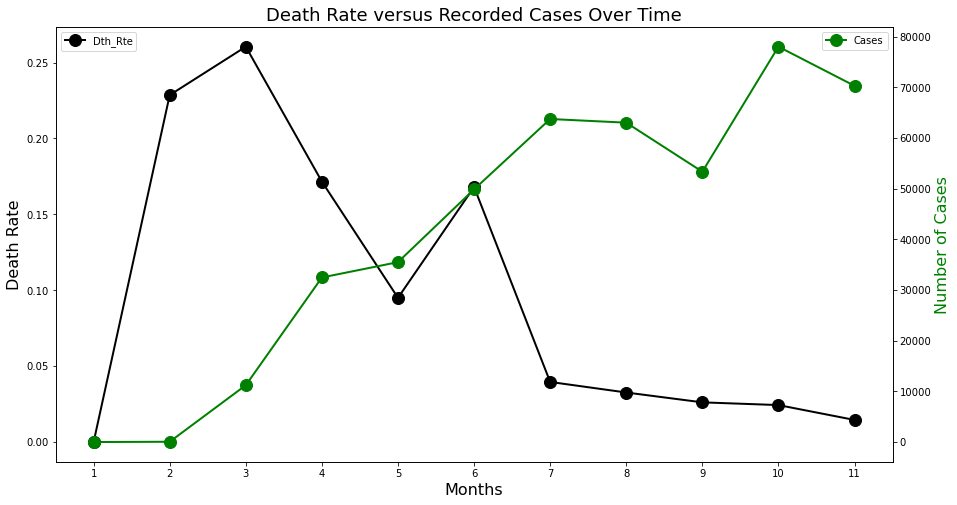

In [43]:
# Generate a line plot of death rate per recorded case over time

#Define plot components
x_axis = month_list
dth_pct_case_cnt = grp_stats_df["Death % of Case Count"]
cse_cnt_rptd = grp_stats_df["Case Count Reported"]


#Charactorize figure size/layout                       
fig = plt.figure(figsize=(15, 8))

#Build and format plot 1
ax1 = fig.add_subplot(111)
ax1.plot(x_axis, dth_pct_case_cnt, linewidth=2, markersize=12,marker="o",color="black", label = "Dth_Rte")
plt.xlabel('Months',fontsize =16)
plt.ylabel('Death Rate',fontsize =16)
plt.legend(loc='upper left')

#Build and format plot 2
ax2=ax1.twinx()
ax2.plot(x_axis, cse_cnt_rptd, linewidth=2, markersize=12,marker="o",color="green", label = "Cases")
plt.legend(loc='upper right')
plt.ylabel('Number of Cases',color="green",fontsize =16)

#define title and Lable axis
plt.title('Death Rate versus Recorded Cases Over Time',fontsize =18)

plt.xticks(x_axis)

#Establish plot limits
#plt.ylim(-.02, .3)

#Save image for potential reference in the report
plt.savefig("./Images/Plots/dth_rte_per_recorded_case_over_time", bbox_inches = "tight")

plt.show()

In [44]:
#Define age grouping 11th month only
df_11 = df.loc[df["month"] == 11,:]

grp_age_stats = df_11.groupby(['age_group','month'])

grp_age_stats.count().head(2)

#Age Calculations
# Sum on Death 
sum_age_dth = grp_age_stats["death_yn"].sum()


#Create a dataframe to enable statistical regression and plotting
grp_stats_age_df = pd.DataFrame({"Age at Death" : sum_age_dth                             
                             })
grp_stats_age_df

,,Age at Death
age_group,month,
0 - 9 Years,11,4.0
10 - 19 Years,11,14.0
20 - 29 Years,11,14.0
30 - 39 Years,11,26.0
40 - 49 Years,11,38.0
50 - 59 Years,11,53.0
60 - 69 Years,11,161.0
70 - 79 Years,11,258.0
80+ Years,11,455.0


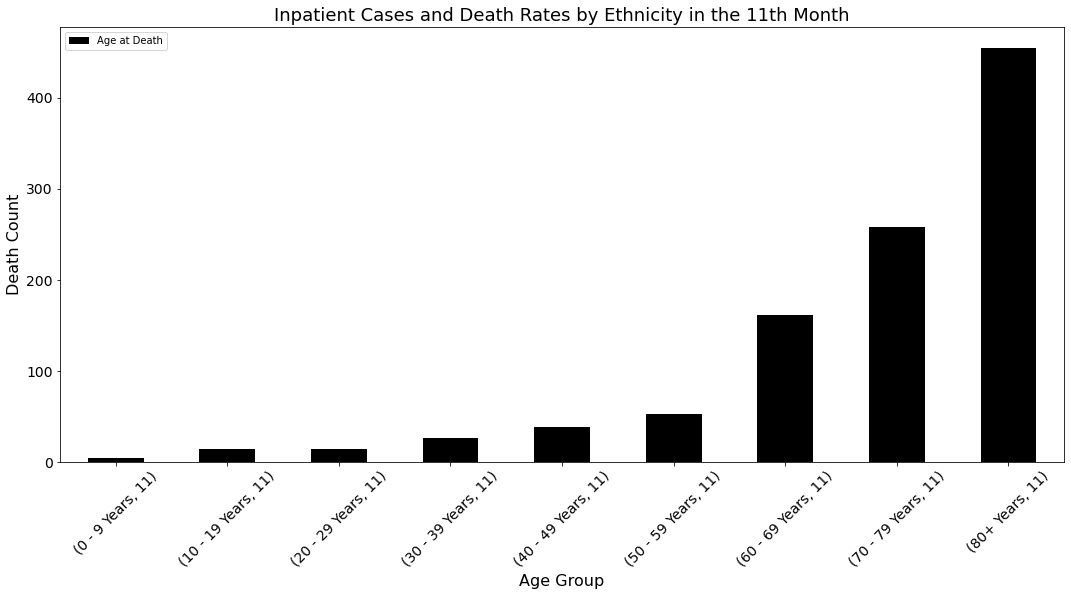

In [45]:
# Generate a bar plot showing the Inpatient Cases and Death Rates by Ethnicity in the 11th Month

#Plot Chart

measure_plot = grp_stats_age_df.plot.bar(figsize=(18,8), color= ['black'],fontsize = 14)
plt.xlabel("Age Group",fontsize = 16)
plt.ylabel("Death Count",fontsize = 16)
plt.title("Inpatient Cases and Death Rates by Ethnicity in the 11th Month",fontsize = 18)
plt.xticks(rotation=45)


#Save image for potential reference in the report
plt.savefig("./Images/Plots/dth_cnt_by_age_grp_plot_by_mnth.png")

plt.show()

In [46]:
#Define Ethnic grouping 11th month only
df_11 = df.loc[df["month"] == 11,:]

grp_ethnic_stats = df_11.groupby(['Race and ethnicity (combined)','month'])

grp_ethnic_stats.count().head(2)

,,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn,inpatient__occupancy,percent_of_inpatients_with_covid
Race and ethnicity (combined),month,,,,,,,,,,,,
Asian,11,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483
Black,11,5614,5614,5614,5614,5614,5614,5614,5614,5614,5614,5614,5614


In [47]:
#Age Calculations
# Sum on Death 
sum_ethnic_dth = grp_ethnic_stats["death_yn"].sum()

#Count of reported
cnt_ethnic_rptd = grp_ethnic_stats["cdc_report_dt"].count()

#Ratio of death to reported
dth_rate_by_ethnicity = sum_ethnic_dth/cnt_ethnic_rptd

#Create a dataframe to enable statistical regression and plotting
grp_stats_ethnic_df = pd.DataFrame({"Cases Reported":cnt_ethnic_rptd,
                                    "Pct of Reported Dying":dth_rate_by_ethnicity                                    
                             })
grp_stats_ethnic_df

,,Cases Reported,Pct of Reported Dying
Race and ethnicity (combined),month,,
Asian,11,1483,0.008766
Black,11,5614,0.016922
Hispanic,11,10413,0.005954
Native,11,187,0.021390
Other,11,2097,0.017167
Pacific Islander,11,313,0.009585
White,11,50205,0.016134


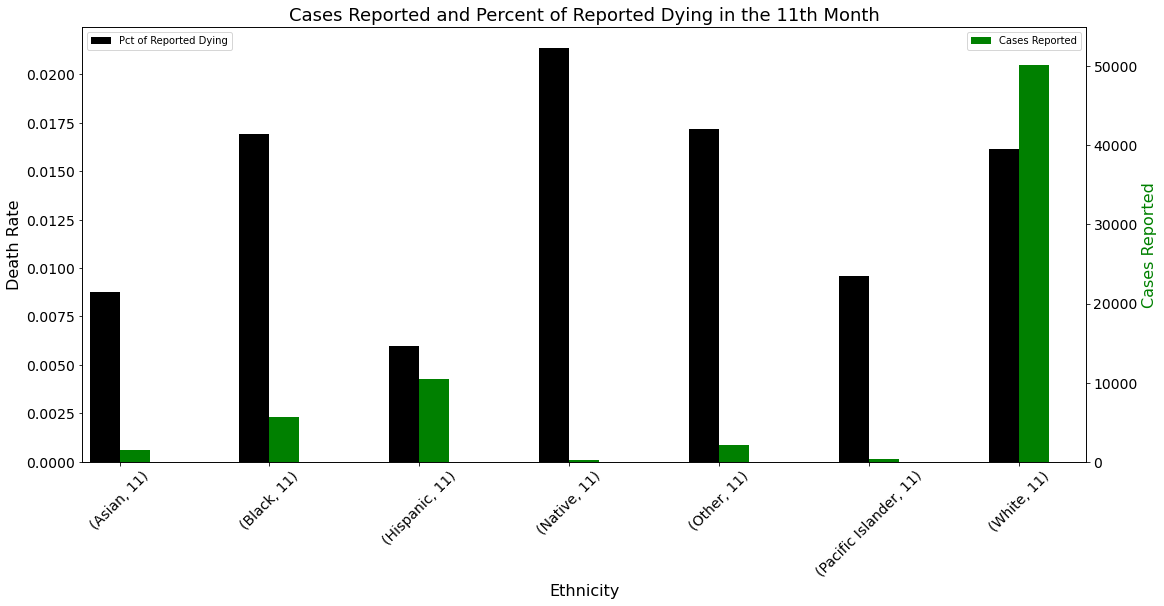

In [48]:
# Generate a bar plot showing the cases reported and percent of reported dying

#Plot Chart
fig = plt.figure(figsize=(15, 8))

width=0.2

#Build and format plot 1
ax1 = fig.add_subplot(111)
grp_stats_ethnic_df['Pct of Reported Dying'].plot.bar(figsize=(18,8), color= ['black'],fontsize = 14, position=1,width=width)
plt.xlabel('Ethnicity',fontsize =16)
plt.ylabel('Death Rate',fontsize =16)
plt.legend(loc='upper left')
plt.xticks(rotation=45)

#Build and format plot 2
ax2=ax1.twinx()
grp_stats_ethnic_df['Cases Reported'].plot.bar(figsize=(18,8), color= ['green'],fontsize = 14, position=0,width=width)
plt.legend(loc='upper right')
plt.ylabel('Cases Reported',color="green",fontsize =16)
plt.ylim(0, 55000)

#define title and Lable axis
plt.title("Cases Reported and Percent of Reported Dying in the 11th Month",fontsize = 18)



#Save image for potential reference in the report
plt.savefig("./Images/Plots/cases_rptd_and_pct_rptd_dth_by_ethnic_grp.png")

plt.show()

# 3. Regression Analysis

In [49]:
# Import dataset

df = pd.read_csv('Data/clean_data.csv')
df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn,month,inpatient__occupancy,percent_of_inpatients_with_covid
0,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
1,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
2,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,1.0,11,0.688734,0.1512
3,2020/11/09,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,0.0,11,0.688734,0.1512
4,2020/11/06,2020/11/10,2020/11/06,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,1.0,11,0.688734,0.1512


## Dummy Variable Classification
Dummy variables are a great way to let the regression software do the heavy lifting in the analysis of causal factors 

The underlying math is actually the same as a groupby average, but it gives our results in terms of regression coefficients, so we can very easily use them to estimate the future

https://conjointly.com/kb/dummy-variables/

In [50]:
# pandas.get_dummies is custom-built for this

# Age:
ageDummies = pd.get_dummies(df['age_group'])
df = pd.merge(df, ageDummies, left_index=True, right_index=True)

# Ethnicity:
ethnoDummies = pd.get_dummies(df['Race and ethnicity (combined)'])
df = pd.merge(df, ethnoDummies, left_index=True, right_index= True)

df.head()


,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,...,60 - 69 Years,70 - 79 Years,80+ Years,Asian,Black,Hispanic,Native,Other,Pacific Islander,White
0,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,2020/11/09,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,2020/11/06,2020/11/10,2020/11/06,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
#REGRESSION: LINEAR PROBABILITY MODEL

# Define input variables
x = df[['sex', 'medcond_yn', '0 - 9 Years', '10 - 19 Years', '20 - 29 Years',
       '30 - 39 Years', '40 - 49 Years', '50 - 59 Years', '60 - 69 Years',
       '70 - 79 Years', '80+ Years', 'Native', 'Asian','Black', 'Hispanic',
       'Other','Pacific Islander','White']]
x = sm.add_constant(x)
# Avoid perfect multicollinearity (comment out these two lines and you'll see that it breaks the regression)
del x['0 - 9 Years']
del x['White']

# Define output variable (death)
y = df['death_yn']

# Ordinary Least Squares Regression
model = sm.OLS(y, x, hasconst= True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     7084.
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:48:57   Log-Likelihood:                 46320.
No. Observations:              457731   AIC:                        -9.261e+04
Df Residuals:                  457714   BIC:                        -9.242e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0467      0.002    -24.540      0.000      -0.050      -0.043
sex                  0.0273      0.001     42.026      0.000       0.026       0.029
medcond_yn           0.0389      0.001     54.978      0.000       0.037       0.040
10 - 19 Years        0.0062      0.002      2.945      0.003       0.002       0.010
20 - 29 Years        0.0066      0.002      3.340      0.001       0.003       0.011
30 - 39 Years        0.0060      0.002      2.981      0.003       0.002       0.010
40 - 49 Years        0.0126      0.002      6.228      0.000       0.009       0.017
50 - 59 Years        0.0364      0.002     18.039      0.000       0.032       0.040
60 - 69 Years        0.0953      0.002     45.980      0.000       0.091       0.099
70 - 79 Years        0.1989      0.002     90.320      0.000       0.195       0.203
80+ Years            0.3986      0.002    172.865      0.000       0.394       0.403
Native               0.0472      0.005      8.724      0.000       0.037       0.058
Asian                0.0556      0.002     28.811      0.000       0.052       0.059
Black                0.0534      0.001     52.091      0.000       0.051       0.055
Hispanic             0.0321      0.001     38.707      0.000       0.030       0.034
Other                0.0241      0.002     12.488      0.000       0.020       0.028
Pacific Islander     0.0186      0.004      4.355      0.000       0.010       0.027
==============================================================================
Omnibus:                   245982.295   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1778601.568
Skew:                           2.551   Prob(JB):                         0.00
Kurtosis:                      11.199   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressing Death: Results
Takeaways:
- Men are 2.73% more likely to die than women (all else equal)
- Those with a medical condition are 3.89% more likely to die than those without (all else equal)
- Age's effect on the likelihood of death is shown in fig. 1
- Ethnicity's effect is shown in fig. 2
 
This is a very promising Linear Probability model. Every single one of our variables has a p-value of 0, meaning our variables are significant. We have quantified many of the risk factors.

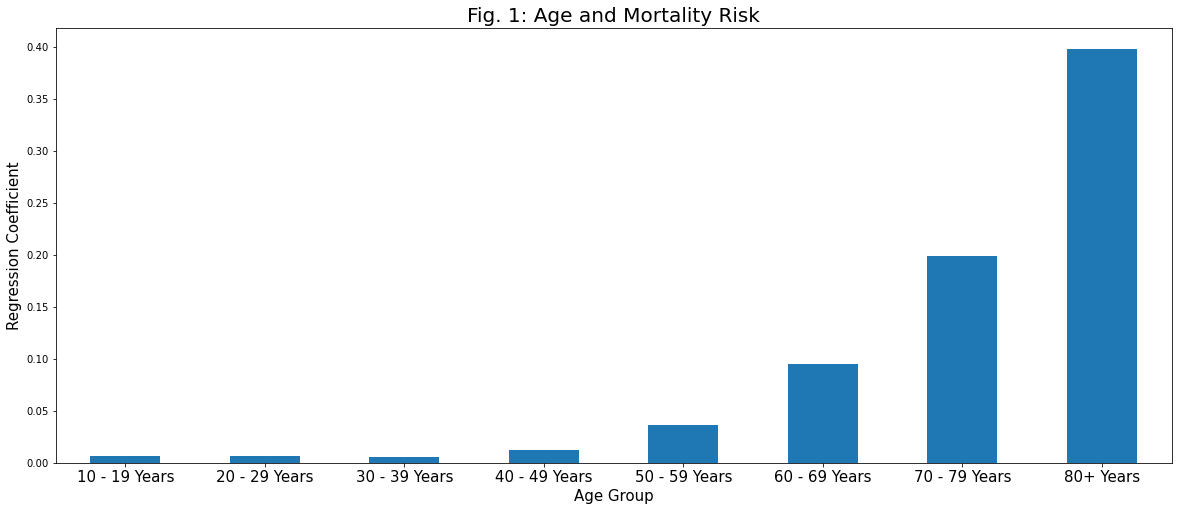

In [52]:
#Figure 1 calculation

plt.figure(figsize = (20,8))
plt.ylabel('Regression Coefficient', fontsize = 15)
plt.xlabel('Age Group', fontsize = 15)
res.params.loc['10 - 19 Years': '80+ Years'].plot(kind = 'bar')
plt.xticks(rotation = 0, fontsize= 15)
plt.title('Fig. 1: Age and Mortality Risk', fontsize = 20)
plt.savefig('Images/Regression/fig1_age.png', facecolor = 'white')
plt.show()


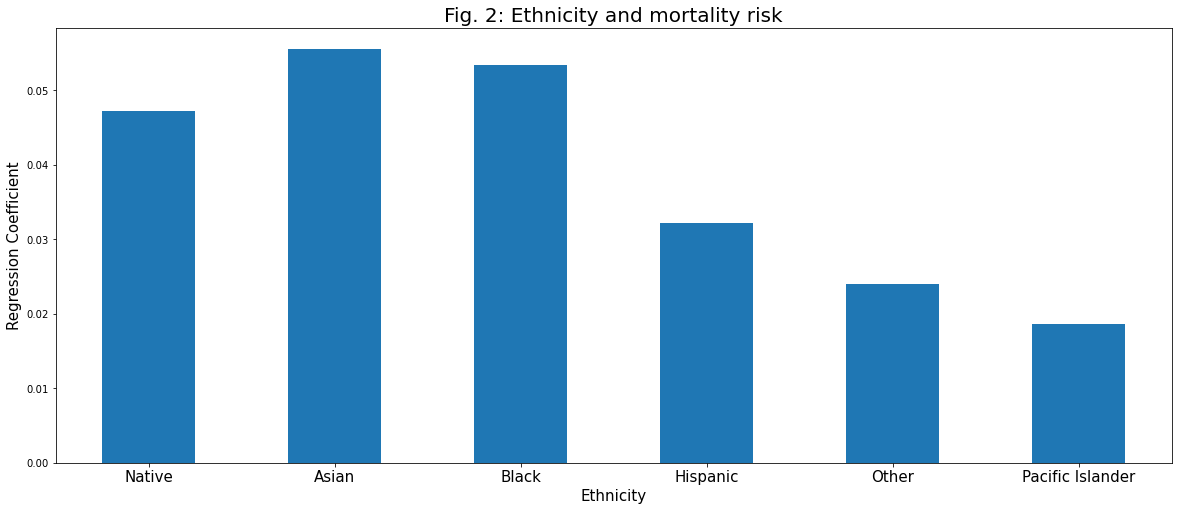

In [53]:
# Figure 2 calculations

plt.figure(figsize = (20,8))
plt.title('Fig. 2: Ethnicity and mortality risk', fontsize = 20)
plt.ylabel('Regression Coefficient', fontsize = 15)
plt.xlabel('Ethnicity', fontsize = 15)

res.params.loc['Native': 'Pacific Islander'].plot(kind = 'bar', )
plt.xticks(rotation = 0, fontsize= 15)
plt.savefig('Images/Regression/fig2_ethnicity.png', facecolor = 'white')
plt.show()

## Predicting Death
So we have demonstrated strong correlation, but what about predictive power? What do our predicted probabilities of death look like when compared with the actual results?

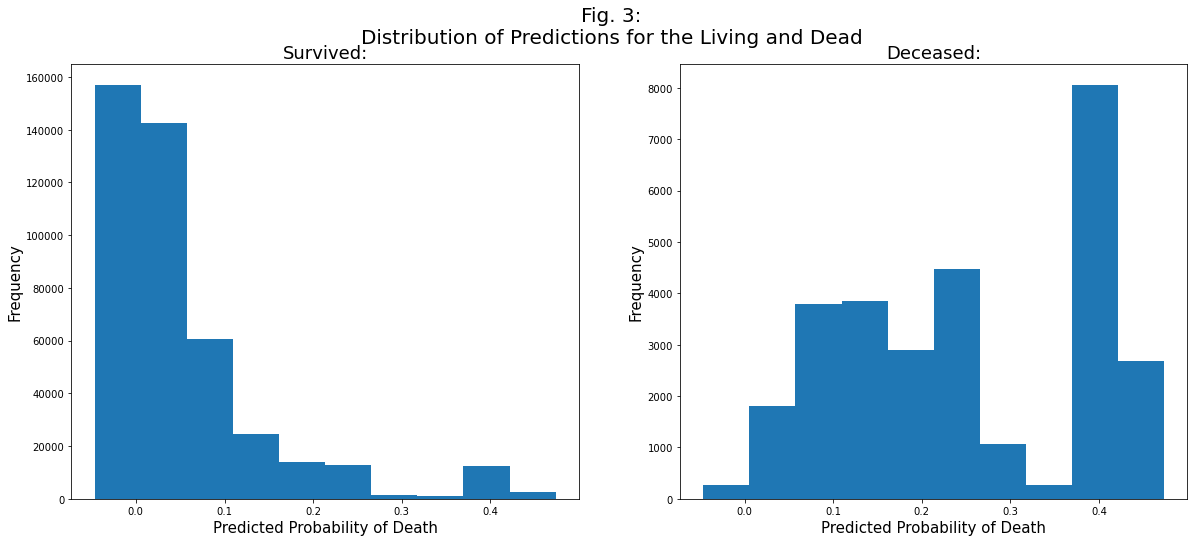

In [54]:
# Generate predictions
df['LPM Prediction'] = res.predict(x)

predictions = df[['LPM Prediction', 'death_yn']]

deaths = predictions[predictions['death_yn'] == True]
lives = predictions[predictions['death_yn'] == False]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 3:\nDistribution of Predictions for the Living and Dead', fontsize= 20)
axs[0].hist(lives['LPM Prediction'])
axs[0].set_title('Survived:', fontsize = 18)
axs[0].set_xlabel('Predicted Probability of Death', fontsize = 15)
axs[0].set_ylabel('Frequency', fontsize = 15)

axs[1].hist(deaths['LPM Prediction'], bins = 10)
axs[1].set_title('Deceased:', fontsize = 18)
axs[1].set_xlabel('Predicted Probability of Death', fontsize= 15)
axs[1].set_ylabel('Frequency', fontsize = 15)

plt.savefig('Images/Regression/fig3_prediction_distribution.png', facecolor = 'white')
plt.show()

## Analyzing Results
It looks like there is a clear pattern between predicted probability of death and actual risk of death. However, the predictions are clearly skewed. The highest predicted probability of death was .46, meaning *no one* was deemed by the model to have a greater chance of dying than surviving. This is due to the fact that only around 6 percent of patients in this dataset ended up dying. 

Even when you look at the population which is most at risk (80+ year olds), 60% of them survived. So it stands to reason that the model would fail to give a patient a 50+% chance of death, when fewer than 50% of even the most vulnerable patients actually passed away.

In [55]:
# Compare summary statistics for living and dead
dead = pd.DataFrame(df[df['death_yn'] == 1]['LPM Prediction'].describe())
alive = pd.DataFrame(df[df['death_yn'] == 0]['LPM Prediction'].describe())

compare = pd.merge(dead, alive, left_index= True, right_index= True, suffixes = ['_dead', '_alive'])
compare.iloc[1:]

,LPM Prediction_dead,LPM Prediction_alive
mean,0.249557,0.051077
std,0.141187,0.093707
min,-0.046668,-0.046668
25%,0.114763,-0.007925
50%,0.218428,0.025667
75%,0.390776,0.075881
max,0.473645,0.473645


In [56]:
# Save dataframe for more in-depth regression 
df.to_csv('Data/regression_dataframe.csv', index= False)

# 3.1 Examining the Effects of Medical Conditions
The purpose of this section is to better understand the effect of pre-existing medical conditions on mortality risk from Covid-19. 

When I saw the relatively small coefficient for the medcond_yn variable in the original regression, I thought we probably needed to introduce some interaction variables into the model. In linear regression, an interaction variable allows for the effect of one variable (age, ethnicity) to depend on another variable (medcond_yn). In this case, it is reasonable to assume that the presence of a medical condition will present a different degree of risk for a 20 year-old, a 50-year old, and an 80 year-old.

We can simply multiply the values of our medcond_yn variable with our dummy classification variables for age and ethnicity. The resulting effect is two regression coefficients per age / ethnicity group. One for those with, and one for those without a pre-existing medical condition. For further reading, check out https://www.theanalysisfactor.com/interaction-dummy-variables-in-linear-regression/

In [57]:
df = pd.read_csv('Data/regression_dataframe.csv')
df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,...,70 - 79 Years,80+ Years,Asian,Black,Hispanic,Native,Other,Pacific Islander,White,LPM Prediction
0,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.040195
1,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.040195
2,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.079077
3,2020/11/09,2020/11/10,2020/11/09,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.040195
4,2020/11/06,2020/11/10,2020/11/06,Laboratory-confirmed case,1.0,10 - 19 Years,Black,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0.079077


,Deaths,Cases,Pct
Without,1671.0,206628,0.808700
With,27498.0,251103,10.950885


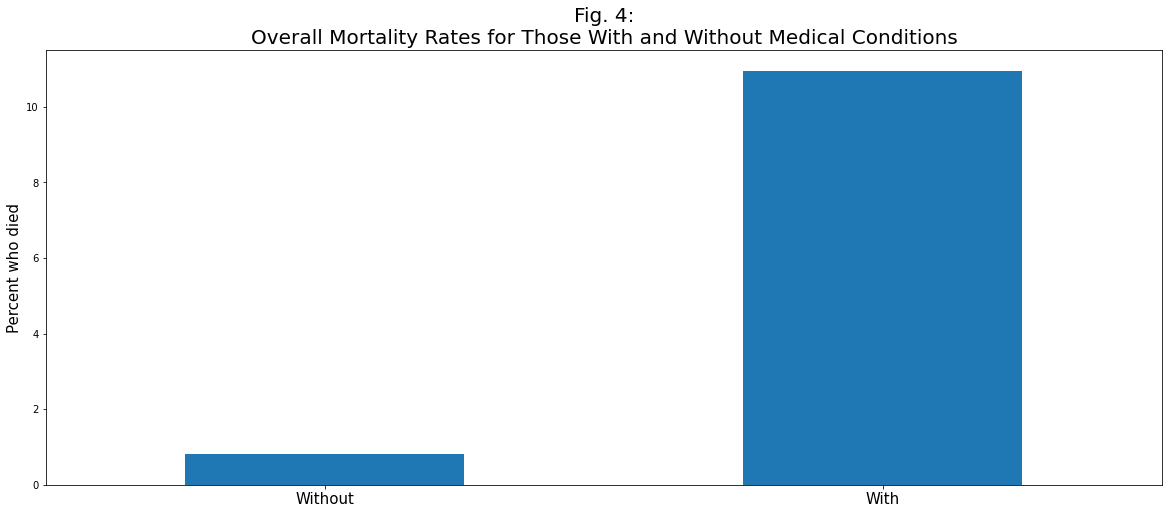

In [58]:
deaths = df.groupby('medcond_yn').sum()['death_yn']
counts = df.groupby('medcond_yn').count()['death_yn']
frame = pd.DataFrame({'Deaths': deaths, 'Cases': counts})
frame['Pct'] = 100 * (frame['Deaths'] / frame['Cases'])
frame.index =['Without', 'With']
frame['Pct'].plot(kind='bar', figsize=(20,8))
plt.ylabel('Percent who died', fontsize = 15)
plt.tick_params(labelrotation = 0)
plt.xticks( fontsize = 15)
plt.title('Fig. 4:\nOverall Mortality Rates for Those With and Without Medical Conditions', fontsize = 20)
plt.savefig('Images/Regression/fig4_medcond_distribution.png', facecolor = 'white')
frame

In [59]:
# Declare which columns will be interacted with
columns = ['20 - 29 Years', '30 - 39 Years',
       '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years',
       '80+ Years', 'Asian', 'Black', 'Hispanic', 'Native', 'Other',
       'Pacific Islander']

interactions = []
# Multiply each column with medcond_yn to create a new column
for col in columns:
    colName = col + '_interact'
    df[colName] = df[col] * df['medcond_yn']
    interactions.append(colName)
df[interactions].head()


,20 - 29 Years_interact,30 - 39 Years_interact,40 - 49 Years_interact,50 - 59 Years_interact,60 - 69 Years_interact,70 - 79 Years_interact,80+ Years_interact,Asian_interact,Black_interact,Hispanic_interact,Native_interact,Other_interact,Pacific Islander_interact
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [60]:
# Perform analysis
exog = ['sex'] + columns + interactions + ['medcond_yn']
x = df[exog]
x = sm.add_constant(x)

y = df['death_yn']

model = sm.OLS(y, x, hasconst = True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4387.
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:49:08   Log-Likelihood:                 50099.
No. Observations:              457731   AIC:                        -1.001e+05
Df Residuals:                  457702   BIC:                        -9.982e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0142      0.001    -11.650      0.000      -0.017      -0.012
sex                           0.0266      0.001     41.286      0.000       0.025       0.028
20 - 29 Years                 0.0009      0.001      0.591      0.554      -0.002       0.004
30 - 39 Years                 0.0008      0.002      0.521      0.602      -0.002       0.004
40 - 49 Years                 0.0040      0.002      2.412      0.016       0.001       0.007
50 - 59 Years                 0.0090      0.002      5.139      0.000       0.006       0.012
60 - 69 Years                 0.0225      0.002     10.399      0.000       0.018       0.027
70 - 79 Years                 0.0646      0.003     20.410      0.000       0.058       0.071
80+ Years                     0.2093      0.004     47.752      0.000       0.201       0.218
Asian                         0.0058      0.003      2.205      0.027       0.001       0.011
Black                         0.0090      0.002      4.981      0.000       0.005       0.012
Hispanic                      0.0031      0.001      2.712      0.007       0.001       0.005
Native                        0.0145      0.009      1.546      0.122      -0.004       0.033
Other                         0.0028      0.003      1.036      0.300      -0.002       0.008
Pacific Islander              0.0170      0.007      2.506      0.012       0.004       0.030
20 - 29 Years_interact        0.0053      0.002      2.143      0.032       0.000       0.010
30 - 39 Years_interact        0.0123      0.003      4.831      0.000       0.007       0.017
40 - 49 Years_interact        0.0231      0.003      9.057      0.000       0.018       0.028
50 - 59 Years_interact        0.0545      0.003     21.325      0.000       0.050       0.060
60 - 69 Years_interact        0.1140      0.003     39.800      0.000       0.108       0.120
70 - 79 Years_interact        0.1809      0.004     48.310      0.000       0.174       0.188
80+ Years_interact            0.2350      0.005     48.375      0.000       0.226       0.245
Asian_interact                0.0963      0.004     25.116      0.000       0.089       0.104
Black_interact                0.0674      0.002     30.879      0.000       0.063       0.072
Hispanic_interact             0.0552      0.002     33.525      0.000       0.052       0.058
Native_interact               0.0535      0.011      4.683      0.000       0.031       0.076
Other_interact                0.0369      0.004      9.661      0.000       0.029       0.044
Pacific Islander_interact     0.0067      0.009      0.769      0.442      -0.010       0.024
medcond_yn                   -0.0273      0.002    -13.696      0.000      -0.031      -0.023
===========================================================================

# Interpretation
Woah! Big change in coefficients!

In the first regression, we estimated that being 80+ years old increased an individual's likelihood of death by around 40%. Now that we have distinguished between those with a medical condition and those without, that number has dropped to 20%. However, 80 year olds *with* a medical condition have an estimated mortality risk of *over* 40% (20.75 + 23.54). 

Where we before estimated that 60-69 year-old patients had an almost 10% increased risk of death, we now have them at just 2%! However, those with a medical condition have around a 14% (2.23 + 11.46) risk of dying!

The inclusion of this interaction variable has really enhanced the specificity of our results. Let's visualize each age group's mortality, ***taking pre-existing conditions into consideration*** 

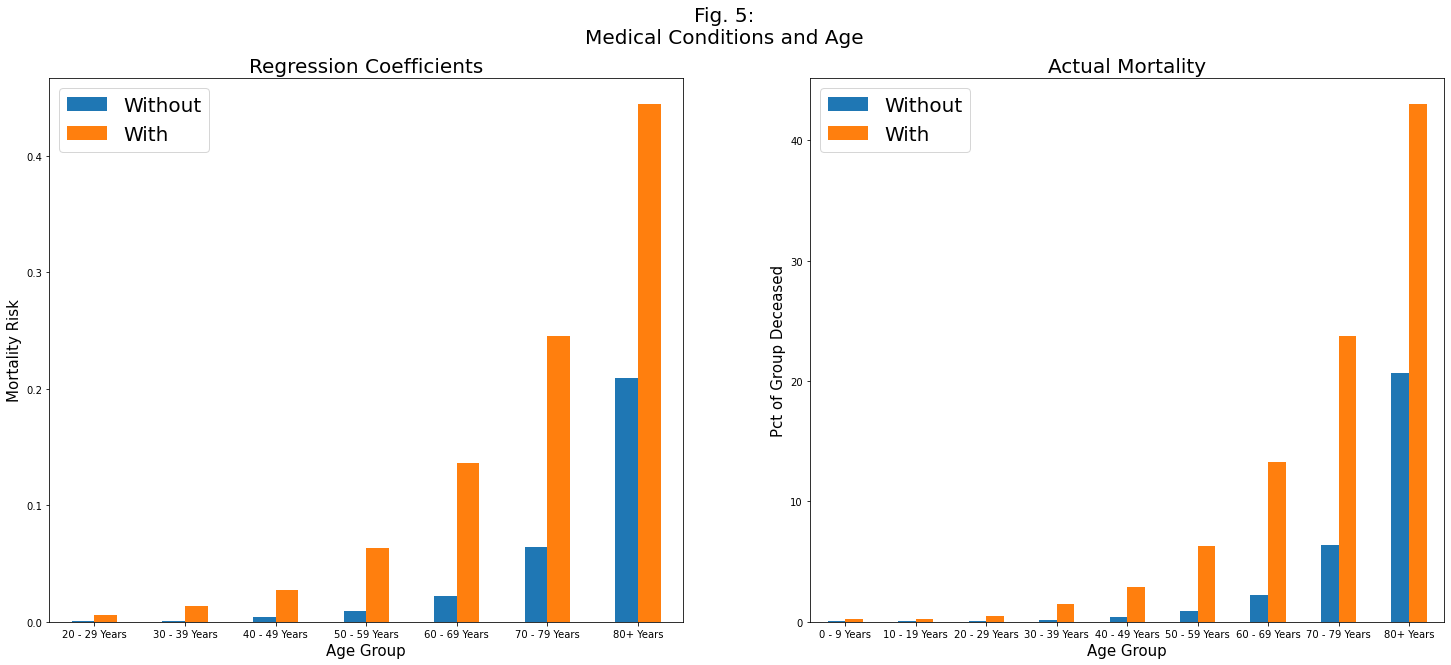

In [61]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 5:\nMedical Conditions and Age', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['20 - 29 Years': '80+ Years']
With = res.params.loc['20 - 29 Years_interact':'80+ Years_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['age_group', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['age_group', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig5_age_and_medcond.png', facecolor = 'white')
plt.show()

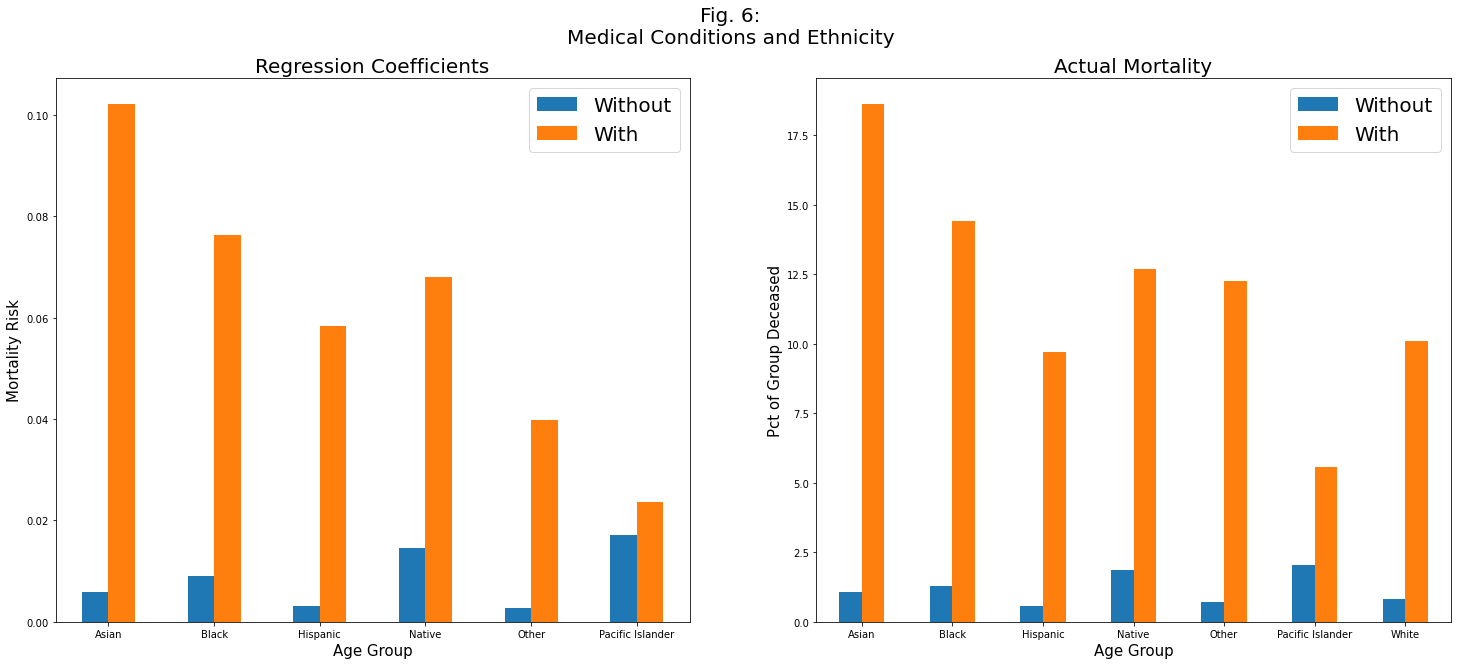

In [62]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 6:\nMedical Conditions and Ethnicity', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['Asian': 'Pacific Islander']
With = res.params.loc['Asian_interact':'Pacific Islander_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['Race and ethnicity (combined)', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['Race and ethnicity (combined)', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig6_ethnicity_and_medcond.png', facecolor = 'white')
plt.show()

## Interpretation
So this graph tells  us two things:
1. Asian and Black people see the highest increased risk of mortality with the presence of pre-existing conditions
2. The presence of pre-existing medical conditions is a much higher risk factor than what the first model initally suggested 

## Why the big change?
Recall that in the first model, the presence of a medical condition was estimated to increase mortality risk by just 3 percent. When specifying by ethnicity and age, however, we see much larger coefficients for the presence of a medical condition. Before, we had not properly specified the model somehow. But how?

One possibility is that the majority of those with medical conditions are young, and they see very little increased risk. If the majority of patients in this dataset are young, then an unspecified regression analysis would see that the majority of those with medical conditions do **not** pass away.

Another possibility is that the majority of those with medical conditions are very *old*, and the regression has "confused" the effect of age with the effect of medical condition. If the majority of those with medical conditions are 80+ years old, and 80+ year-olds see the highest rate of mortality, then an unspecified regression analysis would see a much stronger correlation between *age* and mortality than between the presence of medical conditions and mortality.

Lets look at the distribution of medical conditions by age and see if either of these guesses are correct.

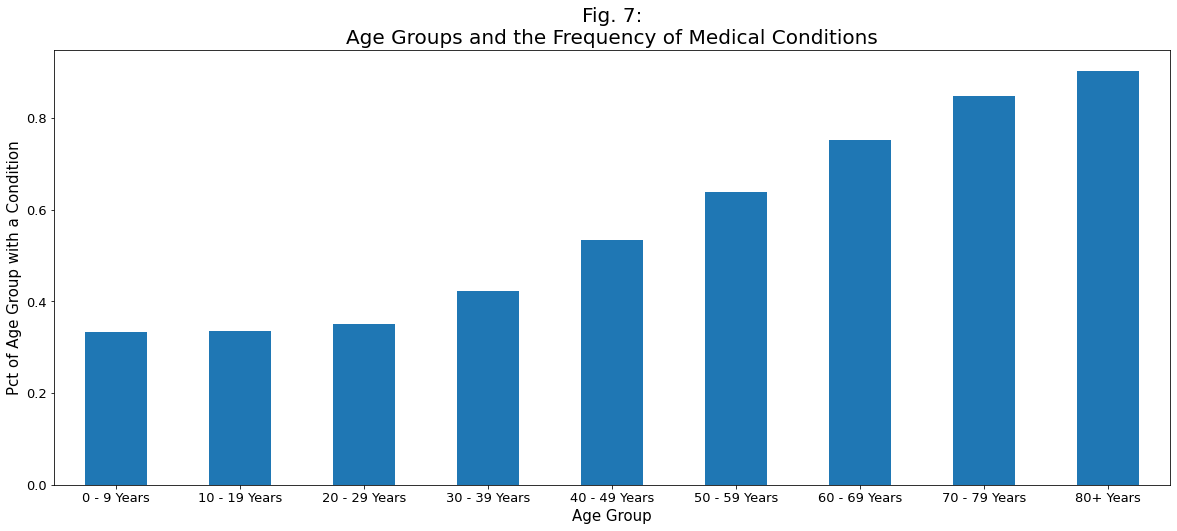

In [63]:
# Group by age group and show intra-group frequency of medical conditions
sums = df.groupby('age_group').sum()['medcond_yn']
counts = df.groupby('age_group').count()['medcond_yn']

totals = pd.DataFrame({'Total With Conditions': sums, 'Total': counts})
totals['Pct'] = totals['Total With Conditions'] / totals['Total']
totals['Pct'].plot(kind = 'bar', figsize = (20,8))
totals['Pct of Pop'] = totals['Total'] / df.shape[0]
plt.ylabel('Pct of Age Group with a Condition', fontsize = 15)
plt.xlabel('Age Group', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Fig. 7:\nAge Groups and the Frequency of Medical Conditions', fontsize = 20)
plt.savefig('Images/Regression/fig7_age_medcond_distribution.png', facecolor = 'white')
plt.show()

## Age Bias
It does, in fact, look like the presence of medical conditions is heavily skewed with age. Not only that, but the majority of observations in this dataset are of individuals younger than 60 years old. In other words, most observations are of people for whom the presence of a medical condition increases mortality risk by less than 10%

This explains why we see such a huge disparity in the medcond_yn coefficients before and after including the interaction variables.

By specifying the intra-group presence of medical conditions, we have painted a much clearer picture of the causes of mortality 

## Predictive Power
Now that we have re-specified our model, we can check its predictive power again.

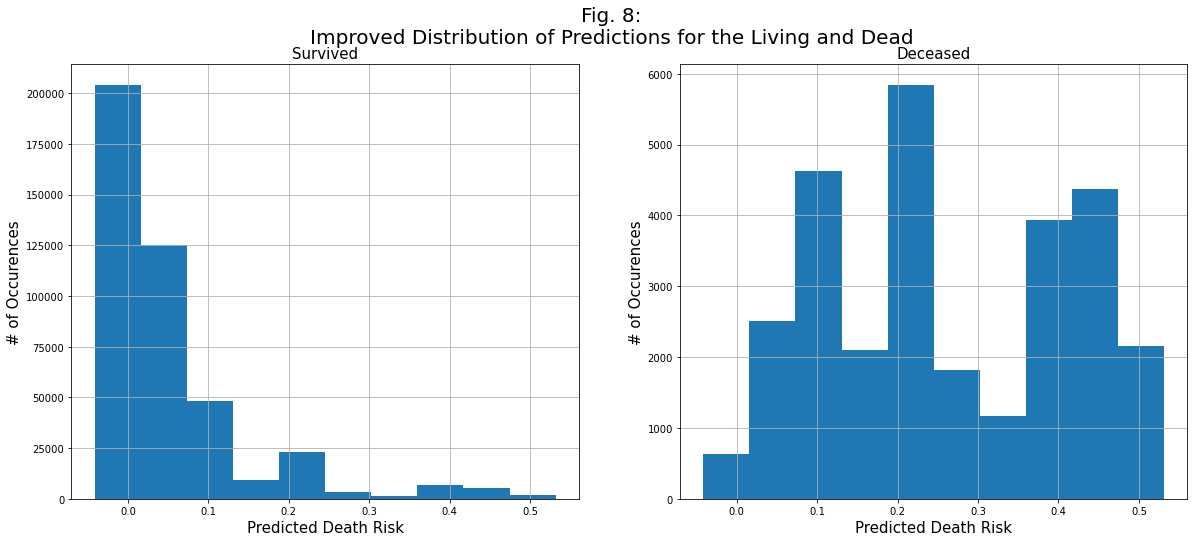

In [64]:
# Replace current prediction estimates (from the last regression)
df['LPM Prediction'] = res.predict(x)
deaths = df[df['death_yn'] == 1]
lives = df[df['death_yn'] == 0]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 8:\nImproved Distribution of Predictions for the Living and Dead', fontsize = 20)
lives['LPM Prediction'].hist(ax = axs[0])
deaths['LPM Prediction'].hist(ax = axs[1])
for ax in axs:
    ax.set_xlabel('Predicted Death Risk', fontsize = 15)
    ax.set_ylabel('# of Occurences', fontsize = 15)

axs[0].set_title('Survived', fontsize = 15)
axs[1].set_title('Deceased', fontsize = 15)

plt.savefig('Images/Regression/fig8_improved_prediction_distribution.png')
plt.show()

## Better fit
Our prediction distribution looks **very** similar to the one from the first regression (Fig. 3) However, it is more skewed in the correct directions (left for the survived, right for the deceased). We have improved our model!
# 3.2 Changes over time
Thus far, we have not taken into account that the treatment options for Covid-19 have greatly improved over time. If we isolate the effect of time's passing, it will better enable us to identify the causal factors behind mortality risk.

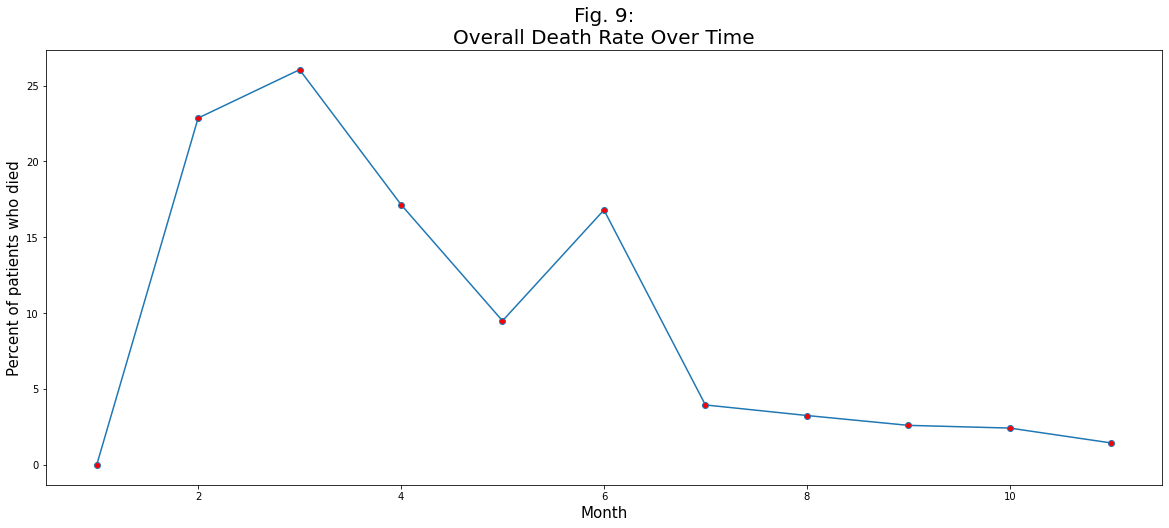

In [65]:
# First, let's visualize it
dead = df.groupby('month').sum()['death_yn']
counts = df.groupby('month').count()['death_yn']
deaths_by_month = pd.DataFrame({'Deaths': dead, 'Cases': counts})
deaths_by_month['Pct'] = (deaths_by_month['Deaths'] / deaths_by_month['Cases']) * 100
deaths_by_month['Pct'].plot(figsize = (20,8), marker = 'o', markerfacecolor = 'r')
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Percent of patients who died', fontsize = 15)
plt.title('Fig. 9:\nOverall Death Rate Over Time', fontsize = 20)
plt.savefig('Images/Regression/fig9_death_over_time.png')

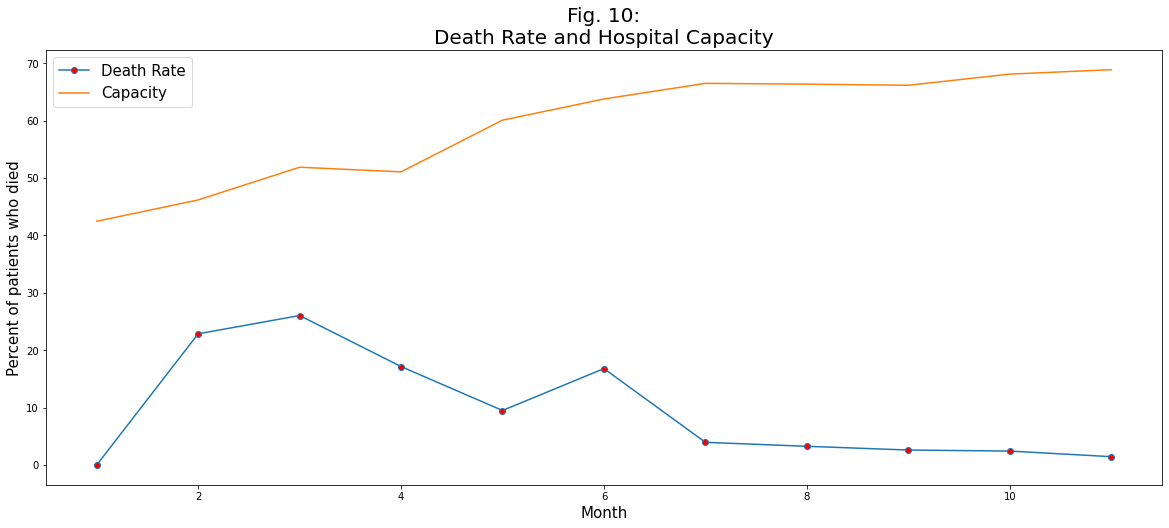

In [66]:
# Grab the occupancy column from the main dataframe
cap = pd.read_csv('Data/clean_data.csv')['inpatient__occupancy']
df['Hospital Capacity'] = cap
cap_by_month = df.groupby('month').mean()['Hospital Capacity'] * 100

# We got the column. Now let's plot it
deaths_by_month['Pct'].plot(figsize = (20,8), marker = 'o', markerfacecolor = 'r')
cap_by_month.plot()
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Percent of patients who died', fontsize = 15)
plt.title('Fig. 10:\nDeath Rate and Hospital Capacity', fontsize = 20)
plt.legend(['Death Rate', 'Capacity'], fontsize = 15)
plt.savefig('Images/Regression/fig10_death_and_capacity.png')

It seems that over time, hospital occupancy has gone up, and the death rate has gone down in spite of this fact. Now, let's quantify the time effect by introducing some time-fixed-effects into our model. Not only will this reflect the trend seen above in Fig. 10, but it will allow the regression software to specify its other coefficients even more accurately due to the mitigation of ommitted variable bias.

In [67]:
months = pd.get_dummies(df['month'])
months

# This for loop is the same as a merge. 
for i in range(2, 12):
    x['month ' + str(i)] = months[i]

x.head()

,const,sex,20 - 29 Years,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,80+ Years,Asian,...,month 2,month 3,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11
0,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
model = sm.OLS(y, x, hasconst = True)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               death_yn   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     3892.
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        23:49:14   Log-Likelihood:                 59769.
No. Observations:              457731   AIC:                        -1.195e+05
Df Residuals:                  457692   BIC:                        -1.190e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0433      0.053     -0.816      0.415      -0.147       0.061
sex                           0.0240      0.001     38.058      0.000       0.023       0.025
20 - 29 Years                -0.0068      0.001     -4.743      0.000      -0.010      -0.004
30 - 39 Years                -0.0095      0.002     -6.183      0.000      -0.012      -0.006
40 - 49 Years                -0.0073      0.002     -4.473      0.000      -0.010      -0.004
50 - 59 Years                -0.0032      0.002     -1.879      0.060      -0.007       0.000
60 - 69 Years                 0.0104      0.002      4.919      0.000       0.006       0.015
70 - 79 Years                 0.0551      0.003     17.777      0.000       0.049       0.061
80+ Years                     0.1950      0.004     45.406      0.000       0.187       0.203
Asian                        -0.0104      0.003     -4.010      0.000      -0.015      -0.005
Black                        -0.0052      0.002     -2.954      0.003      -0.009      -0.002
Hispanic                     -0.0164      0.001    -14.399      0.000      -0.019      -0.014
Native                       -0.0003      0.009     -0.032      0.974      -0.018       0.018
Other                        -0.0037      0.003     -1.393      0.164      -0.009       0.001
Pacific Islander             -0.0059      0.007     -0.884      0.377      -0.019       0.007
20 - 29 Years_interact        0.0022      0.002      0.883      0.377      -0.003       0.007
30 - 39 Years_interact        0.0082      0.003      3.294      0.001       0.003       0.013
40 - 49 Years_interact        0.0196      0.002      7.852      0.000       0.015       0.024
50 - 59 Years_interact        0.0475      0.003     18.946      0.000       0.043       0.052
60 - 69 Years_interact        0.1027      0.003     36.615      0.000       0.097       0.108
70 - 79 Years_interact        0.1640      0.004     44.705      0.000       0.157       0.171
80+ Years_interact            0.2126      0.005     44.654      0.000       0.203       0.222
Asian_interact                0.0874      0.004     23.267      0.000       0.080       0.095
Black_interact                0.0625      0.002     29.241      0.000       0.058       0.067
Hispanic_interact             0.0515      0.002     31.893      0.000       0.048       0.055
Native_interact               0.0640      0.011      5.721      0.000       0.042       0.086
Other_interact                0.0290      0.004      7.746      0.000       0.022       0.036
Pacific Islander_interact     0.0190      0.009      2.227      0.026       0.002       0.036
medcond_yn                   -0.0284      0.002    -14.550      0.000      -0.032      -0.025
month 2                       0.1613      0.059      2.741      0.006      

At first glance, it looks like the size of most of our coefficients have remained the same

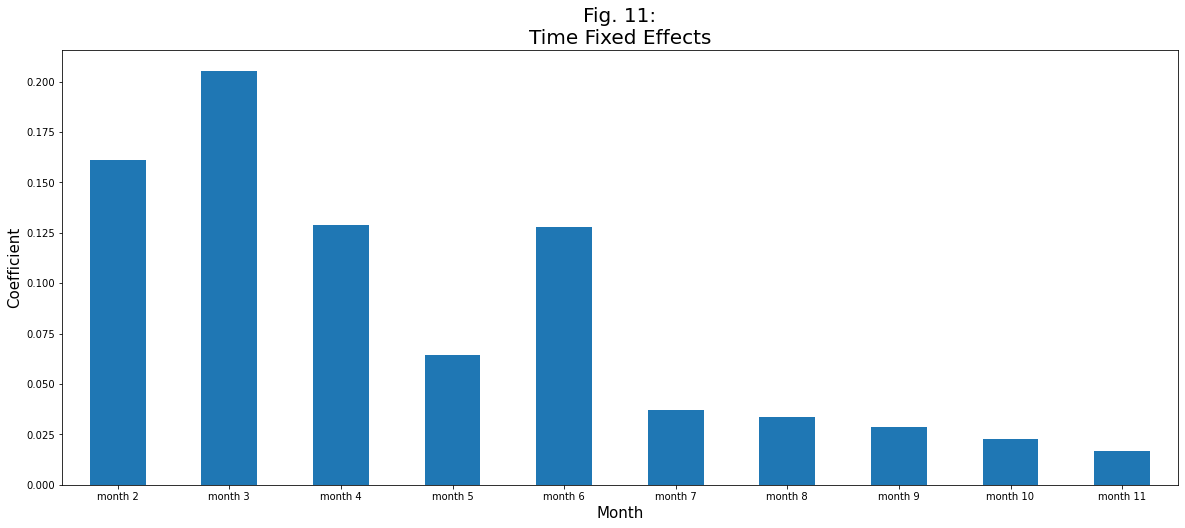

In [69]:
res.params.loc['month 2': 'month 11'].plot(kind = 'bar', figsize = (20,8))
plt.tick_params(labelrotation = 0)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Coefficient', fontsize = 15)
plt.title('Fig. 11:\nTime Fixed Effects', fontsize = 20)
plt.savefig('Images/Regression/fig11_time_fixed_effects')

## Model Respecification
By introducing these time-fixed-effects, we have certainly changed the regression coefficients. Let's see if our above observations continue to hold water after re-specifying the model 

***Note***: *The below code is a copy-paste from the code that generated figures 5 and 6*

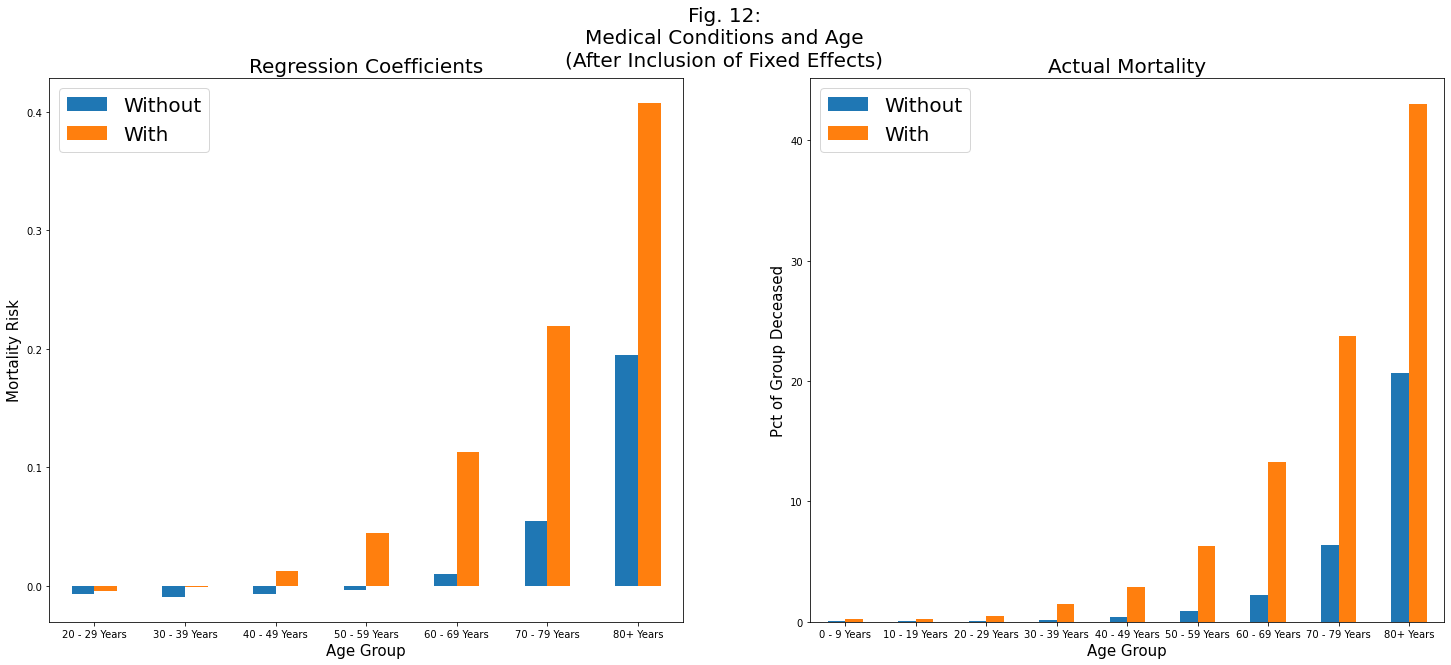

In [70]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 12:\nMedical Conditions and Age\n(After Inclusion of Fixed Effects)', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['20 - 29 Years': '80+ Years']
With = res.params.loc['20 - 29 Years_interact':'80+ Years_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['age_group', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['age_group', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig12_age_and_medcond_post_FE.png', facecolor = 'white')
plt.show()

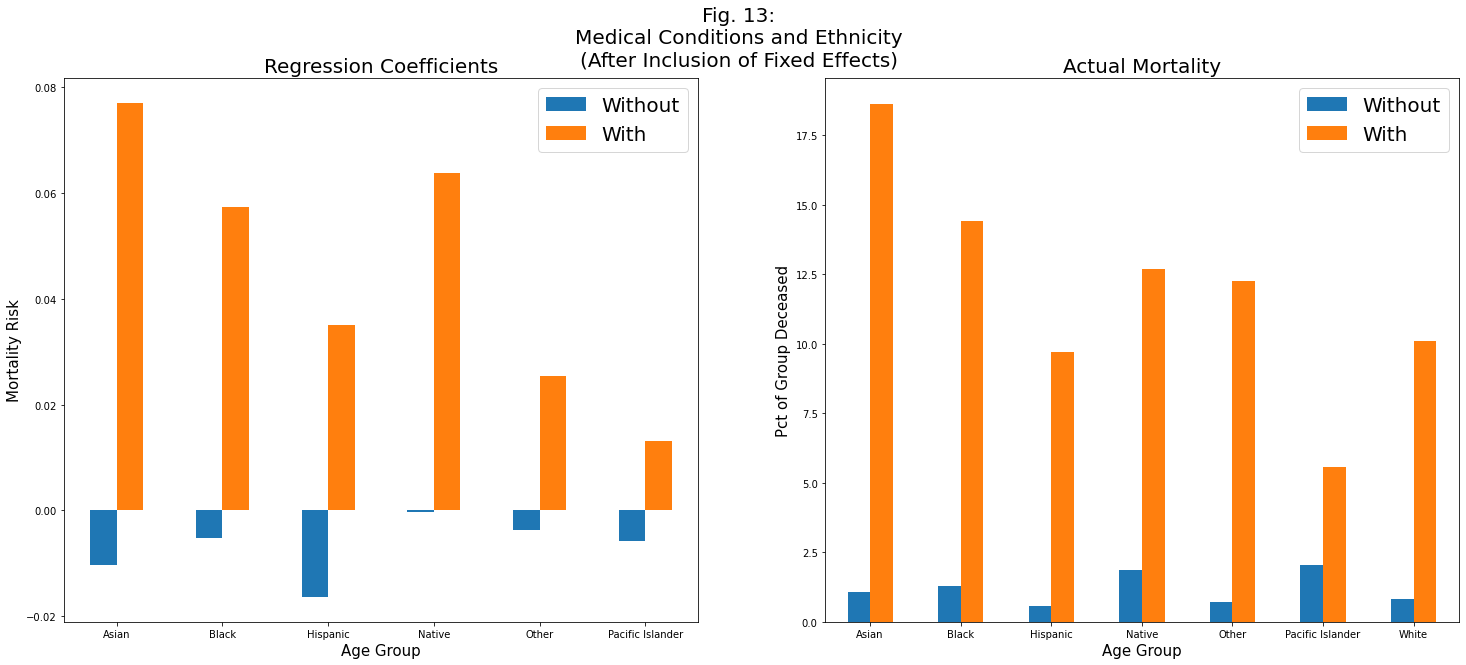

In [71]:
# Plot Setup:
fig, axs = plt.subplots(1, 2, figsize = (25,10))
fig.suptitle('Fig. 13:\nMedical Conditions and Ethnicity\n(After Inclusion of Fixed Effects)', fontsize = 20)

axs[0].set_ylabel('Mortality Risk', fontsize = 15)
axs[1].set_ylabel('Pct of Group Deceased', fontsize = 15)
axs[0].set_title('Regression Coefficients', fontsize = 20)
axs[1].set_title('Actual Mortality', fontsize = 20)


# Coefficients:
Without = res.params.loc['Asian': 'Pacific Islander']
With = res.params.loc['Asian_interact':'Pacific Islander_interact']

coefficients = pd.DataFrame({'Without': Without.values, 'With': Without.values + With.values})
coefficients.set_index(Without.index, inplace = True)

coefficients.plot(kind='bar', ax = axs[0])
axs[0].tick_params(labelrotation = 0)
axs[0].set_xlabel('Age Group', fontsize = 15)
axs[0].legend(['Without', 'With'], fontsize = 20)
#Actual Values:
# Groupby age group and medical condition - compare share of death
sums = df.groupby(['Race and ethnicity (combined)', 'medcond_yn']).sum()['death_yn']
counts = df.groupby(['Race and ethnicity (combined)', 'medcond_yn']).count()['death_yn']
compare = pd.merge(sums, counts, left_index = True, right_index = True).rename(columns = {'death_yn_x': 'Total Deaths',
                                                                                         'death_yn_y': 'Total Cases'})
compare['Pct Dead'] = (compare['Total Deaths'] / compare['Total Cases']) * 100
compare = compare['Pct Dead'].unstack().rename(columns= {0: 'Without', 1: 'With'})

compare.plot(kind='bar', ax = axs[1])
axs[1].set_xlabel('Age Group', fontsize = 15)
axs[1].tick_params(labelrotation = 0)
axs[1].legend(['Without', 'With'], fontsize = 20)

plt.savefig('Images/Regression/fig13_ethnicity_and_medcond_post_FE.png', facecolor = 'white')
plt.show()

One noticeable change: There are now quite a few negative coefficients. If you look close, the pattern is the same as before. 

In other words, ***Relative to each other***, all of our coefficients have maintained the same values. We have simply given more accuracy to the model **overall** by introducing these time-fixed-effects. Our R-squared value rose by 15 percent (0.212 --> 0.244), so that is a good sign. An even better picture would be to repeat the excercise where we show the distribution of predicted probabilities.

*Note: R-squared went up, and that is a positive sign, but for Linear Probability Models, R-squared is a very poor measure of quality. It cannot be interpreted intuitively. That it rose is a good sign, but its value should always be taken with a grain of salt, especially in the case of a Linear Probability Model*

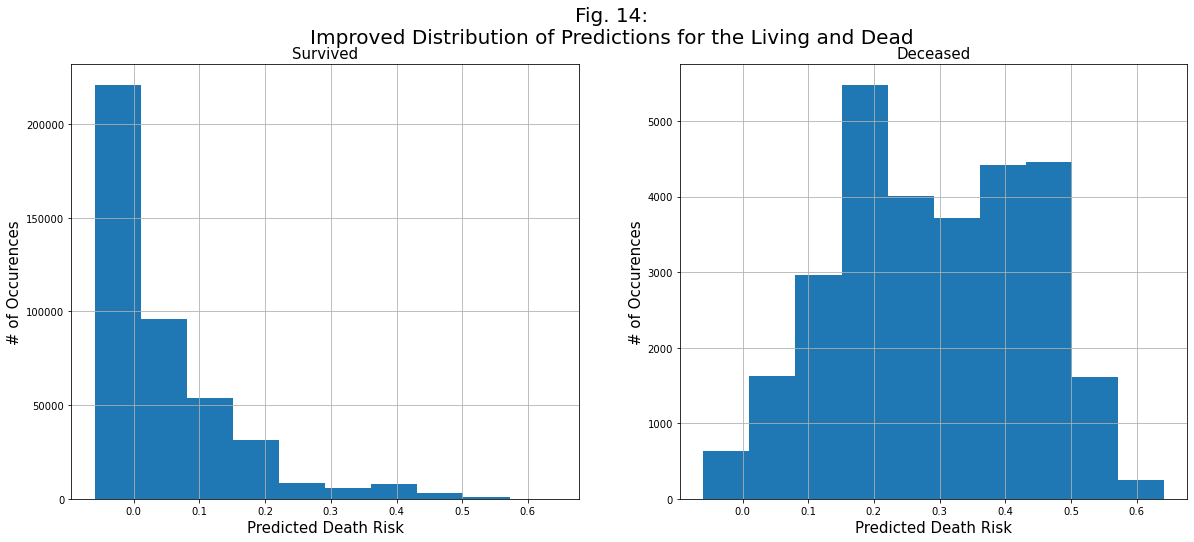

In [72]:
# Replace current prediction estimates (from the last regression)
df['LPM Prediction'] = res.predict(x)
deaths = df[df['death_yn'] == 1]
lives = df[df['death_yn'] == 0]

fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Fig. 14:\nImproved Distribution of Predictions for the Living and Dead', fontsize = 20)
lives['LPM Prediction'].hist(ax = axs[0])
deaths['LPM Prediction'].hist(ax = axs[1])
for ax in axs:
    ax.set_xlabel('Predicted Death Risk', fontsize = 15)
    ax.set_ylabel('# of Occurences', fontsize = 15)

axs[0].set_title('Survived', fontsize = 15)
axs[1].set_title('Deceased', fontsize = 15)

plt.savefig('Images/Regression/fig14_improved_prediction_distribution_post_FE.png')
plt.show()

The distributions have moved *even further* in the correct directions.